In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/home/hazhang/projects/MB_Lung_LDTS3_10132023"

# Data processing

In [ ]:
SELECT * 
FROM sample_methyl_call 
WHERE run_sample_id IN (
    SELECT run_sample_id 
    FROM gh_sample 
    WHERE (cancer_type LIKE '%ung%') AND (use_case = 'mrd') AND (project = 'GH_Reveal_3_0') AND (sample_type = 'Clinical')
)

In [2]:
df_lung_LDT_ghdb = pd.read_csv(f"{work_dir}/Lung_S3_LDT_GHDB.csv", header = 0)
print("Total sample size of the S3 LDT lung cancer by 10/13/2023 is " + str(df_lung_LDT_ghdb.shape[0]) + "\n") 
print("Total sample size of unique the S3 LDT lung cancer by 10/13/2023 is " + str(df_lung_LDT_ghdb.run_sample_id.nunique()) + "\n")

#additional information pulled by Xiaotong
# df_lims = pd.read_csv("/ghds/mrd/users/rchandramohan/analysis/231011_calc_pos_rate_S3/231012_Reveal_S3_LIMS_with_stage.csv", header = 0)
df_lims = pd.read_csv(f"{work_dir}/231016_Reveal_S3_LIMS_with_age.csv", header = 0)
print("Total sample size with information from LIMS pulled by Xiaotong is " + str(df_lims.shape[0]) + "\n") 
print("Total sample size with information from LIMS pulled by Xiaotong is " + str(df_lims.S_SAMPLEID.nunique()) + "\n") 

Total sample size of the S3 LDT lung cancer by 10/13/2023 is 3380

Total sample size of unique the S3 LDT lung cancer by 10/13/2023 is 651

Total sample size with information from LIMS pulled by Xiaotong is 6533

Total sample size with information from LIMS pulled by Xiaotong is 6533



In [3]:
#filter for final S3 caller result
df_lung_LDT_ghdb_lung = df_lung_LDT_ghdb[df_lung_LDT_ghdb["model_name"] == "LUNG"]
print("Total sample size of the S3 LDT lung cancer by 10/13/2023 is " + str(df_lung_LDT_ghdb_lung.shape[0]) + "\n")
print("Total sample size of unique the S3 LDT lung cancer by 10/13/2023 is " + str(df_lung_LDT_ghdb_lung.run_sample_id.nunique()) + "\n")

#check the duplicated 'run_sample_id' 
duplicated_rows = df_lung_LDT_ghdb_lung.duplicated(subset='run_sample_id', keep=False)
duplicates_df = df_lung_LDT_ghdb_lung[duplicated_rows]
#found these samples were ran twice
duplicates_df.head()

Total sample size of the S3 LDT lung cancer by 10/13/2023 is 676

Total sample size of unique the S3 LDT lung cancer by 10/13/2023 is 651



,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob
124,A079768501,230713_A01361_0489_AH5VN3DSX7,68523,LUNG,-2.04962,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,2.12490,-1.842240
129,A079768501,230717_A00274_0888_AH7753DSX7,77629,LUNG,2.37898,0,1,0,LUNG,0.002332,Sirius-1.1.0-RLS,2.38582,-0.259537
229,A079769601,230713_A01112_0418_AH5VTKDSX7,42720,LUNG,6.28086,0,1,0,LUNG,0.022340,Sirius-1.1.0-RLS,2.62451,-0.007117
234,A079769601,230717_A01537_0324_AH7CM2DSX7,70918,LUNG,9.49356,0,1,0,LUNG,0.026820,Sirius-1.1.0-RLS,2.22911,-0.000289
304,A079767401,230713_A01112_0418_AH5VTKDSX7,49280,LUNG,1.78064,0,1,0,LUNG,0.002302,Sirius-1.1.0-RLS,2.47273,-0.395780


In [4]:
#deduplicate
df_lung_LDT = df_lung_LDT_ghdb_lung.drop_duplicates(subset='run_sample_id', keep='first')
print("Total sample size of the S3 LDT lung cancer by 10/13/2023 is " + str(df_lung_LDT.shape[0]) + "\n")

#merge with LIMS information
df_lims_1 = df_lims.copy()
df_lims_1.rename(columns={'S_SAMPLEID': 'run_sample_id'}, inplace=True)
df_lung = pd.merge(df_lung_LDT, df_lims_1, on='run_sample_id', how='left')
print("Total sample size of the S3 LDT lung cancer with LIMS by 10/13/2023 is " + str(df_lung.shape[0]) + "\n")
df_lung_651 = df_lung.copy()

#remove the samples with missing values of in cancer type 
df_lung = df_lung.dropna(subset=['U_DIAGNOSIS'])
print("Total sample size of the S3 LDT lung cancer with cancer type in LIMS by 10/13/2023 is " + str(df_lung.shape[0]) + "\n")
df_lung.head()

Total sample size of the S3 LDT lung cancer by 10/13/2023 is 651

Total sample size of the S3 LDT lung cancer with LIMS by 10/13/2023 is 651

Total sample size of the S3 LDT lung cancer with cancer type in LIMS by 10/13/2023 is 621



,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob,S_REQUESTID,PROJECTID,U_DIAGNOSIS,U_DIAGNOSESOTHER,U_TUMORTYPE,U_PRIMARYSITE,U_CATEGORY,U_SNOMEDDISEASENAME,U_QIAGENTUMORSOURCE,U_QIAGENDISEASENAME,U_ACSDISEASENAME,U_TMB_BUCKET,REPORTED_DATE,U_GHCANCELMASTERID,CANCELLEDREASON,U_CANCERSTAGE,U_AGE
0,A085129401,230920_A01810_0213_BHCF5YDSX7,41023,LUNG,35.89928,0,1,0,LUNG,0.021089,Sirius-1.1.1-RLS,1.31880,-9.643270e-16,A0851294,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-28-2023,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",53.0
1,A083718201,230903_A01537_0333_AHC7WNDSX7,129475,LUNG,-2.25136,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.45724,-1.928710e+00,A0837182,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-06-2023,NaN,NaN,Stage II,80.0
2,A082791801,230819_A01810_0190_BH7K53DSX7,99487,LUNG,2.74765,0,1,0,LUNG,0.000703,Sirius-1.1.1-RLS,1.63237,-1.946830e-01,A0827918,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,08-22-2023,NaN,NaN,Stage II,66.0
3,A080431301,230801_A01835_0097_AH7GGGDSX7,110339,LUNG,-5.28974,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,1.38136,-3.243360e+00,A0804313,GH_Reveal_3_0,Large cell lung carcinoma,NaN,large cell carcinoma,Lung,LUNG,Large cell carcinoma of lung (disorder),Lung,Large cell lung carcinoma,Large cell lung carcinoma,Lung,08-07-2023,NaN,NaN,Stage III,58.0
4,A083417101,230827_A01907_0134_AHCC2VDSX7,21718,LUNG,-10.55169,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.40858,-5.528350e+00,A0834171,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,09-07-2023,NaN,NaN,Stage II,28.0


In [5]:
# Define a function to map age to age group
def map_age_to_group(age):
    if age < 40:
        return '<40'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    elif 60 <= age <= 69:
        return '60-69'
    elif 70 <= age <= 79:
        return '70-79'
    else:
        return '>80'

# Create the 'age_group' column
df_lung['age_group'] = df_lung['U_AGE'].apply(map_age_to_group)

## MB Lung caller 

In [6]:
#used this as WTF to find all the S3 fc_dir as the original WTF script missed some folder
import glob

# Read the CSV file
df_lung_mb_run = df_lung_651.copy()

# Define the path to the 'flowcentral' directory
fc_all_folder = "/ghds/ivd/flowcentral"

# Add a new column 'fc_dir' to the DataFrame with default empty values
df_lung_mb_run['fc_dir'] = ''

# Iterate over each row of the DataFrame
for index, row in df_lung_mb_run.iterrows():
    try:
        runid = row["runid"]
        pattern = f"{fc_all_folder}/*{runid}.*"
        
        # Use the glob function to find folders that match the pattern
        folders = glob.glob(pattern)
        
        # Check if any matching folders were found
        if not folders:
            print(f"No suitable folder found for {runid}")
            df_lung_mb_run.loc[index, "fc_dir"] = ''
        else:
            folder = folders[0]
            df_lung_mb_run.loc[index, "fc_dir"] = folder

    except Exception as e:
        print(f"An error occurred while processing {runid}: {str(e)}")

df_lung_mb_run.head()

,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob,S_REQUESTID,PROJECTID,U_DIAGNOSIS,U_DIAGNOSESOTHER,U_TUMORTYPE,U_PRIMARYSITE,U_CATEGORY,U_SNOMEDDISEASENAME,U_QIAGENTUMORSOURCE,U_QIAGENDISEASENAME,U_ACSDISEASENAME,U_TMB_BUCKET,REPORTED_DATE,U_GHCANCELMASTERID,CANCELLEDREASON,U_CANCERSTAGE,U_AGE,fc_dir
0,A085129401,230920_A01810_0213_BHCF5YDSX7,41023,LUNG,35.89928,0,1,0,LUNG,0.021089,Sirius-1.1.1-RLS,1.31880,-9.643270e-16,A0851294,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-28-2023,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",53.0,/ghds/ivd/flowcentral/230920_A01810_0213_BHCF5YDSX7.ec9553b3-d1a1-4f83-97eb-f5ebe81fac3b.20230922103031
1,A083718201,230903_A01537_0333_AHC7WNDSX7,129475,LUNG,-2.25136,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.45724,-1.928710e+00,A0837182,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-06-2023,NaN,NaN,Stage II,80.0,/ghds/ivd/flowcentral/230903_A01537_0333_AHC7WNDSX7.9fab2dd3-19ad-4dde-9df7-ce79b703eb76.20230905163803
2,A082791801,230819_A01810_0190_BH7K53DSX7,99487,LUNG,2.74765,0,1,0,LUNG,0.000703,Sirius-1.1.1-RLS,1.63237,-1.946830e-01,A0827918,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,08-22-2023,NaN,NaN,Stage II,66.0,/ghds/ivd/flowcentral/230819_A01810_0190_BH7K53DSX7.70c2a1b6-9c2b-4e2b-a0b3-6a216f080582.20230821150152
3,A080431301,230801_A01835_0097_AH7GGGDSX7,110339,LUNG,-5.28974,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,1.38136,-3.243360e+00,A0804313,GH_Reveal_3_0,Large cell lung carcinoma,NaN,large cell carcinoma,Lung,LUNG,Large cell carcinoma of lung (disorder),Lung,Large cell lung carcinoma,Large cell lung carcinoma,Lung,08-07-2023,NaN,NaN,Stage III,58.0,/ghds/ivd/flowcentral/230801_A01835_0097_AH7GGGDSX7.3051efe3-c241-4d24-817f-cd8f9ebc0fc3.20230803144102
4,A083417101,230827_A01907_0134_AHCC2VDSX7,21718,LUNG,-10.55169,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.40858,-5.528350e+00,A0834171,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,09-07-2023,NaN,NaN,Stage II,28.0,/ghds/ivd/flowcentral/230827_A01907_0134_AHCC2VDSX7.9e2c3842-27fc-47c6-a919-b7982d52bb25.20230829145400


In [49]:
# #This code is from Mingyang which works well.
# import subprocess

# def run_mb_caller_wrapper(sample_meta_df, mr_model_file, workdir):
#     """
#     sample_meta_df: consisting of GHSampleID, fc_dir, runid
#     mr_model_file: e.g. /ghds/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv
#     workdir: e.g. /ghess/pharma/projects/sirius_pharma/mrd_ist/lung_mrd_perf_dive/mb_lung_run
#     """

#     # set up workdir
#     if not os.path.exists(workdir):
#         os.mkdir(workdir)
#         os.chdir(workdir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]
#         flowcell_id = row["runid"]
#         out_dir = run_sample_id

#         if not os.path.exists(out_dir):
#             os.mkdir(out_dir)

#         shell_filename = f"{run_sample_id}_MB_submit.sh"

#         shell_header = ("#!/bin/bash\n"
#                         "#$ -S /usr/bin/sh\n"
#                         "#$ -j y\n"
#                         "#$ -V\n"
#                         "#$ -cwd\n"
#                         f"#$ -M hazhang@guardanthealth.com\n"
#                         f"#$ -q dev.q\n"
#                         f"#$ -N run_mb_{run_sample_id}\n"
#                         f"#$ -pe parallel 2\n"
#                         f"#$ -o {work_dir}/run_mb_{run_sample_id}.log\n"
#                         "#$ -l mem_free=20G,h_vmem=20G\n\n")

#         shell_body = (
#             f"""python3 -m epicaller.methylation.methyl_caller \
#             --hyper-molecule-file {fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv \
#             --residual-molecule-file {fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv \
#             --region-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv \
#             --control-region-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv \
#             --lr-model-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv \
#             --mr-model-file {mr_model_file} \
#             --min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 \
#             --sample-id {run_sample_id} --flowcell-id {flowcell_id} \
#             --outdir {out_dir}""")
        
#         with open(shell_filename, "w") as fout:
#             fout.write(shell_header)
#             fout.write(shell_body)

#         subprocess.call(f"qsub {shell_filename}", shell=True)


In [51]:
# run_mb_caller_wrapper(df_lung_mb_run, 
#                       "/ghds/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv", 
#                       "/home/hazhang/projects/MB_Lung_LDTS3_10132023/LDT_S3_MB_lung_output")

Your job 4883891 ("run_mb_A085129401") has been submitted
Your job 4883892 ("run_mb_A083718201") has been submitted
Your job 4883893 ("run_mb_A082791801") has been submitted
Your job 4883894 ("run_mb_A080431301") has been submitted


In [71]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv' 

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{workdir}/LDT_S3_MB_lung_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={workdir}/LDT_S3_MB_lung_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {workdir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [72]:
#run the function to generate all the MB Lung caller ouputs
run_mb_caller_wrapper_slurm(df_lung_mb_run, 
                      "/ghds/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv", 
                      "/home/hazhang/projects/MB_Lung_LDTS3_10132023/LDT_S3_MB_lung_output")

Submitted batch job 69632703
Submitted batch job 69632704
Submitted batch job 69632705
Submitted batch job 69632706
Submitted batch job 69632707
Submitted batch job 69632708
Submitted batch job 69632709
Submitted batch job 69632710
Submitted batch job 69632711
Submitted batch job 69632712
Submitted batch job 69632713
Submitted batch job 69632714
Submitted batch job 69632715
Submitted batch job 69632716
Submitted batch job 69632717
Submitted batch job 69632718
Submitted batch job 69632719
Submitted batch job 69632720
Submitted batch job 69632721
Submitted batch job 69632722
Submitted batch job 69632723
Submitted batch job 69632724
Submitted batch job 69632725
Submitted batch job 69632726
Submitted batch job 69632727
Submitted batch job 69632728
Submitted batch job 69632729
Submitted batch job 69632730
Submitted batch job 69632731
Submitted batch job 69632732
Submitted batch job 69632733
Submitted batch job 69632734
Submitted batch job 69632735
Submitted batch job 69632736
Submitted batc

In [7]:
#retreive and incoporate MB Lung caller results into the currect data
mb_caller_result_folder = f"{work_dir}/LDT_S3_MB_lung_output"

df_result = df_lung.copy()
df_result["MB_methyl_score"] = np.nan

# Process mb_score and mb_model_call
for index, row in df_result.iterrows():
    run_sample_id = row["run_sample_id"]
    msre_mr_file_path = f"{mb_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv"

    #get methylation score of MB caller
    try:
        msre_mr_file_df = pd.read_table(msre_mr_file_path)
        mb_score = msre_mr_file_df['methyl_score'].iloc[0]
        df_result.loc[index, "MB_methyl_score"] = mb_score + 20.03287758915284
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")
        
        
df_result.head()

,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob,S_REQUESTID,PROJECTID,U_DIAGNOSIS,U_DIAGNOSESOTHER,U_TUMORTYPE,U_PRIMARYSITE,U_CATEGORY,U_SNOMEDDISEASENAME,U_QIAGENTUMORSOURCE,U_QIAGENDISEASENAME,U_ACSDISEASENAME,U_TMB_BUCKET,REPORTED_DATE,U_GHCANCELMASTERID,CANCELLEDREASON,U_CANCERSTAGE,U_AGE,age_group,MB_methyl_score
0,A085129401,230920_A01810_0213_BHCF5YDSX7,41023,LUNG,35.89928,0,1,0,LUNG,0.021089,Sirius-1.1.1-RLS,1.31880,-9.643270e-16,A0851294,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-28-2023,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",53.0,50-59,18.331968
1,A083718201,230903_A01537_0333_AHC7WNDSX7,129475,LUNG,-2.25136,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.45724,-1.928710e+00,A0837182,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-06-2023,NaN,NaN,Stage II,80.0,>80,-1.593367
2,A082791801,230819_A01810_0190_BH7K53DSX7,99487,LUNG,2.74765,0,1,0,LUNG,0.000703,Sirius-1.1.1-RLS,1.63237,-1.946830e-01,A0827918,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,08-22-2023,NaN,NaN,Stage II,66.0,60-69,3.842458
3,A080431301,230801_A01835_0097_AH7GGGDSX7,110339,LUNG,-5.28974,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,1.38136,-3.243360e+00,A0804313,GH_Reveal_3_0,Large cell lung carcinoma,NaN,large cell carcinoma,Lung,LUNG,Large cell carcinoma of lung (disorder),Lung,Large cell lung carcinoma,Large cell lung carcinoma,Lung,08-07-2023,NaN,NaN,Stage III,58.0,50-59,-1.144852
4,A083417101,230827_A01907_0134_AHCC2VDSX7,21718,LUNG,-10.55169,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.40858,-5.528350e+00,A0834171,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,09-07-2023,NaN,NaN,Stage II,28.0,<40,-1.924337


In [30]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_v2_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv' 

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{workdir}/LDT_S3_MB_v2_lung_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={workdir}/LDT_S3_MB_v2_lung_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {workdir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [31]:
#run the function to generate all the MB V2 Lung caller ouputs
run_mb_v2_caller_wrapper_slurm(df_lung_mb_run, 
                      "/screening/analysis/2023-Jun-21-lung_dev_reKickoff/results/lung_mafband_adeno_only.10-30-23.tsv", 
                      "/home/hazhang/projects/MB_Lung_LDTS3_10132023/LDT_S3_MB_v2_lung_output")

Submitted batch job 70222638
Submitted batch job 70222639
Submitted batch job 70222640
Submitted batch job 70222641
Submitted batch job 70222642
Submitted batch job 70222643
Submitted batch job 70222644
Submitted batch job 70222645
Submitted batch job 70222646
Submitted batch job 70222647
Submitted batch job 70222648
Submitted batch job 70222649
Submitted batch job 70222650
Submitted batch job 70222651
Submitted batch job 70222652
Submitted batch job 70222653
Submitted batch job 70222654
Submitted batch job 70222655
Submitted batch job 70222656
Submitted batch job 70222657
Submitted batch job 70222658
Submitted batch job 70222659
Submitted batch job 70222660
Submitted batch job 70222661
Submitted batch job 70222662
Submitted batch job 70222663
Submitted batch job 70222664
Submitted batch job 70222665
Submitted batch job 70222666
Submitted batch job 70222667
Submitted batch job 70222668
Submitted batch job 70222669
Submitted batch job 70222670
Submitted batch job 70222671
Submitted batc

In [8]:
#retreive and incoporate MB v2 Lung caller results into the currect data
mb_caller_result_folder = f"{work_dir}/LDT_S3_MB_v2_lung_output"

df_result_1 = df_result.copy()
df_result_1["MB_v2_methyl_score"] = np.nan

# Process mb_score and mb_model_call
for index, row in df_result_1.iterrows():
    run_sample_id = row["run_sample_id"]
    msre_mr_file_path = f"{mb_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv"

    #get methylation score of MB caller
    try:
        msre_mr_file_df = pd.read_table(msre_mr_file_path)
        mb_score = msre_mr_file_df['methyl_score'].iloc[0]
        df_result_1.loc[index, "MB_v2_methyl_score"] = mb_score + 21.222089
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")
        
        
df_result_1.head()

,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob,S_REQUESTID,PROJECTID,U_DIAGNOSIS,U_DIAGNOSESOTHER,U_TUMORTYPE,U_PRIMARYSITE,U_CATEGORY,U_SNOMEDDISEASENAME,U_QIAGENTUMORSOURCE,U_QIAGENDISEASENAME,U_ACSDISEASENAME,U_TMB_BUCKET,REPORTED_DATE,U_GHCANCELMASTERID,CANCELLEDREASON,U_CANCERSTAGE,U_AGE,age_group,MB_methyl_score,MB_v2_methyl_score
0,A085129401,230920_A01810_0213_BHCF5YDSX7,41023,LUNG,35.89928,0,1,0,LUNG,0.021089,Sirius-1.1.1-RLS,1.31880,-9.643270e-16,A0851294,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-28-2023,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",53.0,50-59,18.331968,9.738785
1,A083718201,230903_A01537_0333_AHC7WNDSX7,129475,LUNG,-2.25136,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.45724,-1.928710e+00,A0837182,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-06-2023,NaN,NaN,Stage II,80.0,>80,-1.593367,-0.660962
2,A082791801,230819_A01810_0190_BH7K53DSX7,99487,LUNG,2.74765,0,1,0,LUNG,0.000703,Sirius-1.1.1-RLS,1.63237,-1.946830e-01,A0827918,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,08-22-2023,NaN,NaN,Stage II,66.0,60-69,3.842458,2.034256
3,A080431301,230801_A01835_0097_AH7GGGDSX7,110339,LUNG,-5.28974,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,1.38136,-3.243360e+00,A0804313,GH_Reveal_3_0,Large cell lung carcinoma,NaN,large cell carcinoma,Lung,LUNG,Large cell carcinoma of lung (disorder),Lung,Large cell lung carcinoma,Large cell lung carcinoma,Lung,08-07-2023,NaN,NaN,Stage III,58.0,50-59,-1.144852,-1.149913
4,A083417101,230827_A01907_0134_AHCC2VDSX7,21718,LUNG,-10.55169,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.40858,-5.528350e+00,A0834171,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,09-07-2023,NaN,NaN,Stage II,28.0,<40,-1.924337,-1.436720


In [9]:
df_result = df_result_1.copy()

In [10]:
df_result.shape

(621, 33)

In [11]:
df_result[df_result['MB_v2_methyl_score'] > 0].shape[0]

105

## Incorporate therapy information pulled by Jack

In [12]:
#read in samples with systemic therapy (pre-op) and not systemic theapy (post-treatment) pulled by Jack
df_s3_sys_therapy = pd.read_csv(f"{work_dir}/S3_lung_systemic_therapy.csv", header = 0)
print("Total lung sample size of the S3 LDT that are on therapy is " + str(df_s3_sys_therapy["On therapy"].notna().sum()) + "\n")
print("Total lung sample size of the S3 LDT that are NOT on therapy is " + str(df_s3_sys_therapy["Not on therapy"].notna().sum()) + "\n")
df_s3_sys_therapy.head()

Total lung sample size of the S3 LDT that are on therapy is 80

Total lung sample size of the S3 LDT that are NOT on therapy is 524



,On therapy,Not on therapy
0,A0658618,A0661428
1,A0694516,A0676649
2,A0777244,A0703248
3,A0784096,A0706567
4,A0786393,A0727272


In [13]:
# Extract the unique values from 'On therapy' and 'Not on therapy' columns, dropping any NaNs
on_therapy_values = df_s3_sys_therapy['On therapy'].dropna().unique()
not_on_therapy_values = df_s3_sys_therapy['Not on therapy'].dropna().unique()

# Define functions to map 'On therapy' and 'Not on therapy' values based on prefix match
def map_on_therapy(run_sample_id):
    if run_sample_id[:-2] in on_therapy_values:
        return run_sample_id[:-2]
    return np.nan

def map_not_on_therapy(run_sample_id):
    if run_sample_id[:-2] in not_on_therapy_values:
        return run_sample_id[:-2]
    return np.nan

# Apply the mapping functions
df_lung = df_result.copy()
df_lung['on_therapy_request_id'] = df_lung['run_sample_id'].apply(map_on_therapy)
df_lung['not_on_therapy_request_id'] = df_lung['run_sample_id'].apply(map_not_on_therapy)

# Now for the 'therapy' column
def map_therapy(run_sample_id):
    if run_sample_id[:-2] in on_therapy_values:
        return 1
    elif run_sample_id[:-2] in not_on_therapy_values:
        return 0
    else:
        return np.nan

df_lung['therapy'] = df_lung['run_sample_id'].apply(map_therapy)
df_lung.head()

,run_sample_id,runid,hyper_residual_count_pos_ctrl,model_name,methyl_score,threshold,methyl_call,call,pred_type,pred_frac,analysis_version,ctrl_cor_frac,log10_prob,S_REQUESTID,PROJECTID,U_DIAGNOSIS,U_DIAGNOSESOTHER,U_TUMORTYPE,U_PRIMARYSITE,U_CATEGORY,U_SNOMEDDISEASENAME,U_QIAGENTUMORSOURCE,U_QIAGENDISEASENAME,U_ACSDISEASENAME,U_TMB_BUCKET,REPORTED_DATE,U_GHCANCELMASTERID,CANCELLEDREASON,U_CANCERSTAGE,U_AGE,age_group,MB_methyl_score,MB_v2_methyl_score,on_therapy_request_id,not_on_therapy_request_id,therapy
0,A085129401,230920_A01810_0213_BHCF5YDSX7,41023,LUNG,35.89928,0,1,0,LUNG,0.021089,Sirius-1.1.1-RLS,1.31880,-9.643270e-16,A0851294,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-28-2023,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",53.0,50-59,18.331968,9.738785,NaN,A0851294,0.0
1,A083718201,230903_A01537_0333_AHC7WNDSX7,129475,LUNG,-2.25136,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.45724,-1.928710e+00,A0837182,GH_Reveal_3_0,Lung squamous cell carcinoma,NaN,squamous cell carcinoma,Lung,LUNG,Squamous cell carcinoma of lung (disorder),Lung,Lung squamous cell carcinoma,Lung squamous cell carcinoma,Lung,09-06-2023,NaN,NaN,Stage II,80.0,>80,-1.593367,-0.660962,NaN,A0837182,0.0
2,A082791801,230819_A01810_0190_BH7K53DSX7,99487,LUNG,2.74765,0,1,0,LUNG,0.000703,Sirius-1.1.1-RLS,1.63237,-1.946830e-01,A0827918,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,08-22-2023,NaN,NaN,Stage II,66.0,60-69,3.842458,2.034256,NaN,A0827918,0.0
3,A080431301,230801_A01835_0097_AH7GGGDSX7,110339,LUNG,-5.28974,0,0,0,cancer_free,0.000000,Sirius-1.1.0-RLS,1.38136,-3.243360e+00,A0804313,GH_Reveal_3_0,Large cell lung carcinoma,NaN,large cell carcinoma,Lung,LUNG,Large cell carcinoma of lung (disorder),Lung,Large cell lung carcinoma,Large cell lung carcinoma,Lung,08-07-2023,NaN,NaN,Stage III,58.0,50-59,-1.144852,-1.149913,NaN,A0804313,0.0
4,A083417101,230827_A01907_0134_AHCC2VDSX7,21718,LUNG,-10.55169,0,0,0,cancer_free,0.000000,Sirius-1.1.1-RLS,1.40858,-5.528350e+00,A0834171,GH_Reveal_3_0,Lung adenocarcinoma,NaN,adenocarcinoma,Lung,LUNG,Adenocarcinoma of lung (disorder),Lung,Lung adenocarcinoma,Lung adenocarcinoma,Lung,09-07-2023,NaN,NaN,Stage II,28.0,<40,-1.924337,-1.436720,NaN,A0834171,0.0


In [14]:
#filter by on therapy and not on therapy
df_lung_s3_mb = df_lung.copy()
df_therapy = df_lung_s3_mb[df_lung_s3_mb["therapy"] == 1]
print("Total sample size of the on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is " + str(df_therapy.shape[0]) + "\n")
df_no_therapy = df_lung_s3_mb[df_lung_s3_mb["therapy"] == 0]
print("Total sample size of the NOT on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is " + str(df_no_therapy.shape[0]) + "\n")

Total sample size of the on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is 77

Total sample size of the NOT on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is 514



### Process MB Lung cancer samples that generated by Che-yu

In [8]:
# #read LDT S3 MB Lung caller results generated by Che-yu
# df_LDT_S3_mb = pd.read_table(f"{work_dir}/MRD_LDT_samples_all_models_new_mb_warmstart.tsv")
# print("Total sample size of the S3 LDT with MB Lung caller result generated by Che-yu is " + str(df_LDT_S3_mb.shape[0]) + "\n")

# #filter for lung cancer patient only
# df_LDT_S3_mb_lung = df_LDT_S3_mb[df_LDT_S3_mb["cancer_type"] == "lung"]
# print("Total sample size of the S3 LDT Lung cancer patients with MB Lung caller result generated by Che-yu is " + str(df_LDT_S3_mb_lung.shape[0]) + "\n")

# #select MB lung caller related features
# df_LDT_S3_mb_lung = df_LDT_S3_mb_lung.loc[:, ["run_sample_id", "age", "New_MB"]]

# #select subset of the sample and merge the information
# list_lung = df_LDT_S3_mb_lung.run_sample_id.tolist()
# df_LDT_S3_mb_lung_with_epiTF = df_lung[df_lung.run_sample_id.isin(list_lung)]

# #merge additional information
# df_LDT_S3_mb_lung_with_epiTF = df_LDT_S3_mb_lung_with_epiTF.merge(df_LDT_S3_mb_lung[["run_sample_id", "age", "New_MB"]], on = "run_sample_id", how = "left")
# #bring the "New_MB" value 20.03287758915284 up so that using 0 as the cutoff
# df_LDT_S3_mb_lung_with_epiTF["New_MB"] = df_LDT_S3_mb_lung_with_epiTF["New_MB"] + 20.03287758915284
# print("Total sample size of the S3 LDT Lung cancer patients with MB Lung caller result generated by Che-yu and has LIMS information is " + str(df_LDT_S3_mb_lung_with_epiTF.shape[0]) + "\n")

Total sample size of the S3 LDT with MB Lung caller result generated by Che-yu is 3731

Total sample size of the S3 LDT Lung cancer patients with MB Lung caller result generated by Che-yu is 398

Total sample size of the S3 LDT Lung cancer patients with MB Lung caller result generated by Che-yu and has LIMS information is 367



In [22]:
# #filter by on therapy and not on therapy
# df_lung_s3_mb = df_LDT_S3_mb_lung_with_epiTF.copy()
# df_therapy = df_lung_s3_mb[df_lung_s3_mb["therapy"] == 1]
# print("Total sample size of the on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is " + str(df_therapy.shape[0]) + "\n")
# df_no_therapy = df_lung_s3_mb[df_lung_s3_mb["therapy"] == 0]
# print("Total sample size of the NOT on therapy S3 LDT Lung cancer patients with both S3 and MB Lung caller result is " + str(df_no_therapy.shape[0]) + "\n")

# Generate summary tables  

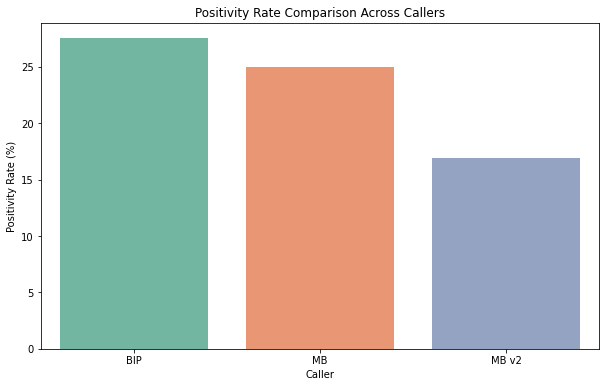

2.179521146497592e-05

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pandas as pd

def plot_positivity_rates_and_test(df):
    # Calculate total samples and positivity rates
    total_samples = len(df)
    total_positive_calls = len(df[df['methyl_call'] == 1])
    total_negative_calls = total_samples - total_positive_calls

    total_positive_calls_MB = len(df[df['MB_methyl_score'] > 0])
    total_negative_calls_MB = total_samples - total_positive_calls_MB

    total_positive_calls_MB_v2 = len(df[df['MB_v2_methyl_score'] > 0])
    total_negative_calls_MB_v2 = total_samples - total_positive_calls_MB_v2

    positivity_rate = total_positive_calls / total_samples * 100
    positivity_rate_mb = total_positive_calls_MB / total_samples * 100
    positivity_rate_mb_v2 = total_positive_calls_MB_v2 / total_samples * 100

    # Create a DataFrame for the plot
    plot_data = pd.DataFrame({
        'Caller': ['BIP', 'MB', 'MB v2'],
        'Positivity Rate': [f"{positivity_rate:.1f}% (n={total_positive_calls}/{total_samples})", 
                            f"{positivity_rate_mb:.1f}% (n={total_positive_calls_MB}/{total_samples})", 
                            f"{positivity_rate_mb_v2:.1f}% (n={total_positive_calls_MB_v2}/{total_samples})"],
        'Positivity Rate Value': [positivity_rate, positivity_rate_mb, positivity_rate_mb_v2]
    })

    # Contingency table for chi-square test
    contingency_table = [
        [total_positive_calls, total_negative_calls],
        [total_positive_calls_MB, total_negative_calls_MB],
        [total_positive_calls_MB_v2, total_negative_calls_MB_v2]
    ]

    # Perform chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Plotting the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Caller', y='Positivity Rate Value', data=plot_data, palette='Set2')
    plt.title(f'Positivity Rate Comparison Across Callers')
    plt.ylabel('Positivity Rate (%)')
    plt.show()

    return plot_data, p_value

# Example usage with your DataFrame
df_plot, p_value = plot_positivity_rates_and_test(df_lung)
df_plot
p_value

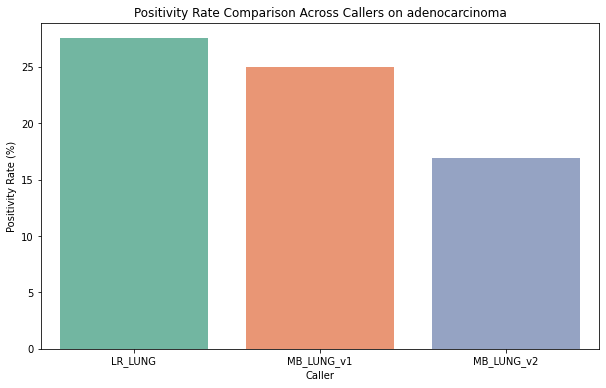

,Caller,Positivity Rate,Positivity Rate Value
0,LR_LUNG,27.5% (n=171/621),27.536232
1,MB_LUNG_v1,25.0% (n=155/621),24.959742
2,MB_LUNG_v2,16.9% (n=105/621),16.908213


In [22]:
def plot_positivity_rates(df):
    # Calculate total samples and positivity rates
    total_samples = len(df)
    total_positive_calls = len(df[df['methyl_call'] == 1])
    total_positive_calls_MB = len(df[df['MB_methyl_score'] > 0])
    total_positive_calls_MB_v2 = len(df[df['MB_v2_methyl_score'] > 0])

    positivity_rate = total_positive_calls / total_samples * 100
    positivity_rate_mb = total_positive_calls_MB / total_samples * 100
    positivity_rate_mb_v2 = total_positive_calls_MB_v2 / total_samples * 100

    # Create a DataFrame for the plot
    plot_data = pd.DataFrame({
        'Caller': ['LR_LUNG', 'MB_LUNG_v1', 'MB_LUNG_v2'],
        'Positivity Rate': [f"{positivity_rate:.1f}% (n={total_positive_calls}/{total_samples})", 
                            f"{positivity_rate_mb:.1f}% (n={total_positive_calls_MB}/{total_samples})", 
                            f"{positivity_rate_mb_v2:.1f}% (n={total_positive_calls_MB_v2}/{total_samples})"],
        'Positivity Rate Value': [positivity_rate, positivity_rate_mb, positivity_rate_mb_v2]
    })

    # Plotting the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Caller', y='Positivity Rate Value', data=plot_data, palette='Set2')
    plt.title('Positivity Rate Comparison Across Callers on adenocarcinoma')
    plt.ylabel('Positivity Rate (%)')
    plt.show()

    return plot_data

df_positive_rate = plot_positivity_rates(df_lung)
df_positive_rate

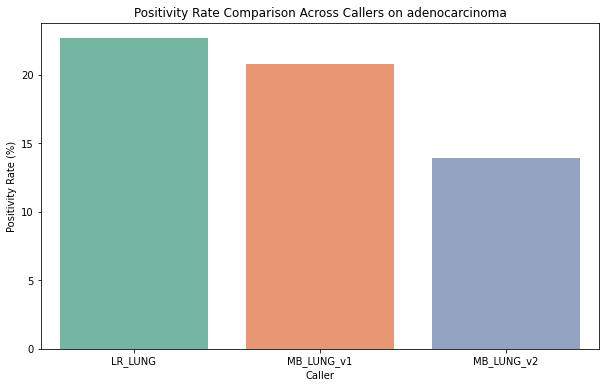

,Caller,Positivity Rate,Positivity Rate Value
0,LR_LUNG,22.7% (n=109/481),22.661123
1,MB_LUNG_v1,20.8% (n=100/481),20.790021
2,MB_LUNG_v2,13.9% (n=67/481),13.929314


In [23]:
#check the detection rate of adeno vs squamous
filtered_pos_calls_df = df_lung[df_lung['U_DIAGNOSIS'].isin(['Lung adenocarcinoma', 'Lung squamous cell carcinoma'])]
df_adeno = df_lung[df_lung['U_DIAGNOSIS'].isin(['Lung adenocarcinoma'])]
df_squa = df_lung[df_lung['U_DIAGNOSIS'].isin(['Lung squamous cell carcinoma'])]
df_positive_rate_adeno = plot_positivity_rates(df_adeno)
df_positive_rate_adeno

In [32]:
#generate summary table
def generate_summary_groupby_one(df, groupby_col):
    """
    Generate a summary based on the given groupby column.

    Parameters:
    - df: The DataFrame to generate summary for.
    - groupby_col (str): The column name to group by.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """

    # Group the DataFrame by the specified column
    grouped = df.groupby([groupby_col])

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_key, group in grouped:
        
        # Total samples
        total_samples = len(group)
        
        # Filter samples where "call" == 1
        positive_calls = group[group['methyl_call'] == 1]
        
        # Calculate Positivity Rate
        positivity_rate = len(positive_calls) / total_samples
        
        # Calculate Median Tumor Fraction for samples where "call" == 1
        median_tumor_frac = positive_calls['pred_frac'].median()
        
        # Calculate Median Methylation Score for samples where "call" == 1
        median_methylation_score = positive_calls['methyl_score'].median()
        
        # Create a summary dictionary for this group
        summary_dict = {
            groupby_col: group_key,
            'Positivity Rate': f"{positivity_rate * 100:.1f}% (n={len(positive_calls)}/{total_samples})",
            'Median Tumor Fraction': median_tumor_frac,
            'Median Methylation Score': median_methylation_score
        }

        # If grouping by 'therapy', handle the NaN to boolean conversion
        if groupby_col == 'therapy' and pd.notna(group_key):
            summary_dict['Systemic therapy'] = bool(group_key)

        # Append the summary dictionary to the summary data list
        summary_data.append(summary_dict)

    # Convert summary data to DataFrame and return
    return pd.DataFrame(summary_data)

# Use the function to generate summaries
summary_stage = generate_summary_groupby_one(df_lung, 'U_CANCERSTAGE')
summary_therapy = generate_summary_groupby_one(df_lung, 'therapy')

In [33]:
summary_stage

,U_CANCERSTAGE,Positivity Rate,Median Tumor Fraction,Median Methylation Score
0,Stage I/II,21.7% (n=15/69),0.001306,1.63761
1,Stage II,24.9% (n=49/197),0.001098,1.72232
2,Stage III,28.0% (n=83/296),0.001299,3.21268
3,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",40.7% (n=24/59),0.001335,4.00287


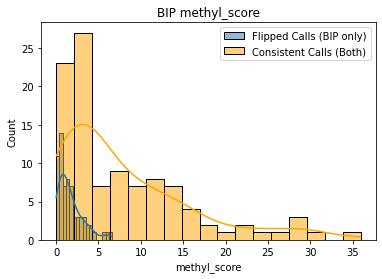

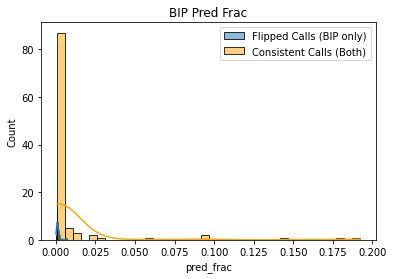

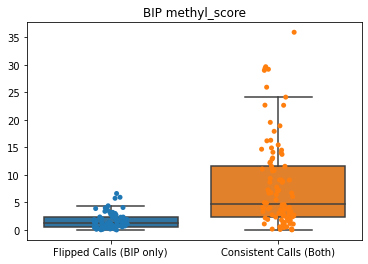

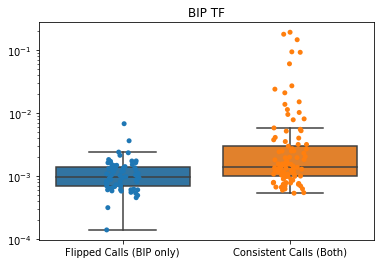

Wilcoxon rank-sum test p-value for Methyl Score: 0.00000
Wilcoxon rank-sum test p-value for Pred Frac: 0.00000
Group			N	Median Methylation Score (BIP caller)	Wilcoxon rank-sum test
Flipped Calls (BIP only)	67	1.29
Consistent Calls (Both)	104	4.73	p = 2.40e-12
Wilcoxon rank-sum test p-value for pred_frac: 0.00000
Group			N	Median TF (BIP caller)	Wilcoxon rank-sum test
Flipped Calls (BIP only)	67	0.000989498
Consistent Calls (Both)	104	0.001422950	p = 2.91e-06


In [21]:
from scipy.stats import chi2_contingency, fisher_exact, ranksums

group = df_lung.copy()

# Initialize a list to store summary data
summary_data = []

total_samples = len(group)
positive_calls = group[group['methyl_call'] == 1]
positive_calls_MB = group[group['MB_methyl_score'] > 0]

positivity_rate = len(positive_calls) / total_samples
positivity_rate_mb = len(positive_calls_MB) / total_samples

bip_pos = len(positive_calls)
bip_neg = total_samples - bip_pos

mb_pos = len(positive_calls_MB)
mb_neg = total_samples - mb_pos

contingency = [[bip_pos, bip_neg], [mb_pos, mb_neg]]
bip_only_count = len(positive_calls[~positive_calls.index.isin(positive_calls_MB.index)])
mb_only_count = len(positive_calls_MB[~positive_calls_MB.index.isin(positive_calls.index)])
consistent_calls_both = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index)])

try:
    _, p_value, _, _ = chi2_contingency(contingency)
except ValueError:
    _, p_value = fisher_exact(contingency)

summary_dict = {
    'Positivity Rate (BIP caller)': f"{positivity_rate * 100:.1f}% (n={bip_pos}/{total_samples})",
    'Positivity Rate (MB caller)': f"{positivity_rate_mb * 100:.1f}% (n={mb_pos}/{total_samples})",
    'chi-square p value': p_value,
    'Median Tumor Fraction (BIP caller)': positive_calls['pred_frac'].median(),
    'Median Methylation Score (BIP caller)': positive_calls['methyl_score'].median(),
    'Median Tumor Fraction (MB caller)': positive_calls_MB['pred_frac'].median(),
    'Median Methylation Score (MB caller)': positive_calls_MB['MB_methyl_score'].median(),
    'Flipped Calls (BIP only)': bip_only_count,
    'Flipped Calls (MB only)': mb_only_count,
    'Consistent Calls (Both)': consistent_calls_both
}

summary_data.append(summary_dict)
summary_df = pd.DataFrame(summary_data)
flipped_calls_df = positive_calls[~positive_calls.index.isin(positive_calls_MB.index)]
consistent_calls_df = positive_calls[positive_calls.index.isin(positive_calls_MB.index)]

desired_bin_width_methyl = 2
max_value_methyl = max(flipped_calls_df["methyl_score"].max(), consistent_calls_df["methyl_score"].max())
min_value_methyl = min(flipped_calls_df["methyl_score"].min(), consistent_calls_df["methyl_score"].min())
n_bins_methyl = int((max_value_methyl - min_value_methyl) / desired_bin_width_methyl)

sns.histplot(data=flipped_calls_df, x="methyl_score", kde=True, label="Flipped Calls (BIP only)", bins=n_bins_methyl)
sns.histplot(data=consistent_calls_df, x="methyl_score", kde=True, color="orange", label="Consistent Calls (Both)", bins=n_bins_methyl)
plt.legend()
plt.title("BIP methyl_score")
plt.show()

desired_bin_width = 0.005
max_value = max(flipped_calls_df["pred_frac"].max(), consistent_calls_df["pred_frac"].max())
min_value = min(flipped_calls_df["pred_frac"].min(), consistent_calls_df["pred_frac"].min())
n_bins = int((max_value - min_value) / desired_bin_width)

sns.histplot(data=flipped_calls_df, x="pred_frac", kde=True, label="Flipped Calls (BIP only)", bins=n_bins)
sns.histplot(data=consistent_calls_df, x="pred_frac", kde=True, color="orange", label="Consistent Calls (Both)", bins=n_bins)
plt.legend()
plt.title("BIP Pred Frac")
plt.show()

ax = sns.boxplot(data=[flipped_calls_df["methyl_score"], consistent_calls_df["methyl_score"]], showfliers=False)
sns.stripplot(data=[flipped_calls_df["methyl_score"], consistent_calls_df["methyl_score"]], jitter=True, size=5, ax=ax)
plt.xticks([0, 1], ["Flipped Calls (BIP only)", "Consistent Calls (Both)"])
plt.title("BIP methyl_score")
plt.show()

ax = sns.boxplot(data=[flipped_calls_df["pred_frac"], consistent_calls_df["pred_frac"]], showfliers=False)
sns.stripplot(data=[flipped_calls_df["pred_frac"], consistent_calls_df["pred_frac"]], jitter=True, size=5, ax=ax)
ax.set_yscale("log")
plt.xticks([0, 1], ["Flipped Calls (BIP only)", "Consistent Calls (Both)"])
plt.title("BIP TF")
plt.show()

z_stat, p_val_methyl_score = ranksums(flipped_calls_df["methyl_score"], consistent_calls_df["methyl_score"])
print(f"Wilcoxon rank-sum test p-value for Methyl Score: {p_val_methyl_score:.5f}")
z_stat, p_val_pred_frac = ranksums(flipped_calls_df["pred_frac"], consistent_calls_df["pred_frac"])
print(f"Wilcoxon rank-sum test p-value for Pred Frac: {p_val_pred_frac:.5f}")

print("Group\t\t\tN\tMedian Methylation Score (BIP caller)\tWilcoxon rank-sum test")
print(f"Flipped Calls (BIP only)\t{len(flipped_calls_df)}\t{flipped_calls_df['methyl_score'].median():.2f}")
print(f"Consistent Calls (Both)\t{len(consistent_calls_df)}\t{consistent_calls_df['methyl_score'].median():.2f}\tp = {p_val_methyl_score:.2e}")

z_stat, p_val_pred_frac = ranksums(flipped_calls_df["pred_frac"], consistent_calls_df["pred_frac"])
print(f"Wilcoxon rank-sum test p-value for pred_frac: {p_val_pred_frac:.5f}")
print("Group\t\t\tN\tMedian TF (BIP caller)\tWilcoxon rank-sum test")
print(f"Flipped Calls (BIP only)\t{len(flipped_calls_df)}\t{flipped_calls_df['pred_frac'].median():.9f}")
print(f"Consistent Calls (Both)\t{len(consistent_calls_df)}\t{consistent_calls_df['pred_frac'].median():.9f}\tp = {p_val_pred_frac:.2e}")


In [26]:
#generate summary table
def generate_summary_groupby_one_MB(df, groupby_col):
    """
    Generate a summary based on the given groupby column.

    Parameters:
    - df: The DataFrame to generate summary for.
    - groupby_col (str): The column name to group by.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """

    # Group the DataFrame by the specified column
    grouped = df.groupby([groupby_col])

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_key, group in grouped:
        
        # Total samples
        total_samples = len(group)
        
        # Filter samples where "call" == 1
        positive_calls = group[group['MB_methyl_score'] > 0]
        
        # Calculate Positivity Rate
        positivity_rate = len(positive_calls) / total_samples
        
        # Calculate Median Tumor Fraction for samples where "call" == 1
        median_tumor_frac = positive_calls['pred_frac'].median()
        
        # Calculate Median Methylation Score for samples where "call" == 1
        median_methylation_score = positive_calls['MB_methyl_score'].median()
        
        # Create a summary dictionary for this group
        summary_dict = {
            groupby_col: group_key,
            'Positivity Rate (MB Caller)': f"{positivity_rate * 100:.1f}% (n={len(positive_calls)}/{total_samples})",
            'Median Tumor Fraction (MB Caller)': median_tumor_frac,
            'Median Methylation Score (MB Caller)': median_methylation_score
        }

        # If grouping by 'therapy', handle the NaN to boolean conversion
        if groupby_col == 'therapy' and pd.notna(group_key):
            summary_dict['Systemic therapy'] = bool(group_key)

        # Append the summary dictionary to the summary data list
        summary_data.append(summary_dict)

    # Convert summary data to DataFrame and return
    return pd.DataFrame(summary_data)

summary_therapy_mb = generate_summary_groupby_one_MB(df_lung, 'therapy')

In [27]:
summary_therapy_mb

,therapy,Positivity Rate (MB Caller),Median Tumor Fraction (MB Caller),Median Methylation Score (MB Caller),Systemic therapy
0,0.0,23.7% (n=122/514),0.001088,1.699459,False
1,1.0,36.4% (n=28/77),0.000891,0.995174,True


In [16]:
def generate_summary_groupby_two(df, groupby_cols, filename, work_dir=""):
    """
    Generate a summary based on the given two groupby columns.

    Parameters:
    - df: The DataFrame to generate summary for.
    - groupby_col (str): The column name to group by.
    - filename (str): The file name that you want to save as.
    - work_dir="": Working dir path. 
    
    
    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """
    # Group by the specified columns
    grouped = df.groupby(groupby_cols)
    
    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_keys, group in grouped:
        
        # Total samples
        total_samples = len(group)

        # Filter samples where "call" == 1 for positive BIP run call
        positive_calls = group[group['methyl_call'] == 1]

        # Calculate Positivity Rate
        positivity_rate = len(positive_calls) / total_samples

        # Calculate Median Tumor Fraction for samples where "call" == 1
        median_tumor_frac = positive_calls['pred_frac'].median()

        # Calculate Median Methylation Score for samples where "call" == 1
        median_methylation_score = positive_calls['methyl_score'].median()
        
        summary_dict = {
            'Positivity Rate': f"{positivity_rate * 100:.1f}% (n={len(positive_calls)}/{total_samples})",
            'Median Tumor Fraction': median_tumor_frac,
            'Median Methylation Score': median_methylation_score
        }
        
        # Extend dictionary with groupby columns and their values
        for col, value in zip(groupby_cols, group_keys):
            summary_dict[col] = value

        # Append summary data for this group
        summary_data.append(summary_dict)

    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Save the data
    summary_df.to_csv(f"{work_dir}/{filename}", index=False)
    
    return summary_df

# Generate summary based on cancer type and stage 
summary_type_stage = generate_summary_groupby_two(df_lung, ['U_DIAGNOSIS', 'U_CANCERSTAGE'], "lung_LDT_summary_type_stage.csv", work_dir)

# Generate summary based on cancer type and age group
summary_type_age = generate_summary_groupby_two(df_lung, ['U_DIAGNOSIS', 'age_group'], "lung_LDT_summary_type_age.csv", work_dir)

# Generate summary based on cancer type and therapy
summary_type_therapy = generate_summary_groupby_two(df_lung, ['U_DIAGNOSIS', 'therapy'], "lung_LDT_summary_type_therapy.csv", work_dir)

In [17]:
summary_type_age

,Positivity Rate,Median Tumor Fraction,Median Methylation Score,U_DIAGNOSIS,age_group
0,0.0% (n=0/2),NaN,NaN,Large cell lung carcinoma,50-59
1,20.0% (n=1/5),0.004039,16.191620,Large cell lung carcinoma,60-69
2,50.0% (n=2/4),0.001124,1.485455,Large cell lung carcinoma,70-79
3,25.0% (n=3/12),0.000659,1.435780,Lung adenocarcinoma,40-49
4,16.7% (n=9/54),0.001340,3.155020,Lung adenocarcinoma,50-59
5,21.9% (n=44/201),0.001293,2.084010,Lung adenocarcinoma,60-69
6,23.2% (n=36/155),0.001183,3.137815,Lung adenocarcinoma,70-79
7,0.0% (n=0/3),NaN,NaN,Lung adenocarcinoma,<40
8,30.4% (n=17/56),0.001201,1.872640,Lung adenocarcinoma,>80
9,0.0% (n=0/1),NaN,NaN,Lung adenosquamous carcinoma,70-79


In [18]:
#generate comparison summary table between S3 and MB caller result with flipped call information groupby one column
from scipy.stats import chi2_contingency, fisher_exact

def generate_comparison_summary_one_column(df, groupby_col, filename, work_dir=""):
    """
    Generate a summary comparing BIP caller and MB caller when grouping by one column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to generate summary for.
    - groupby_col (str): The column name to group by.
    - filename (str): The name of the file to save the summary to.
    - work_dir (str, optional): The working directory to save the file. Default is current directory.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """
    
    # Group the DataFrame by the specified column
    grouped = df.groupby(groupby_col)

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_key, group in grouped:
        
        # Total samples
        total_samples = len(group)

        # Filter samples based on various criteria
        positive_calls = group[group['methyl_call'] == 1]
        positive_calls_MB = group[group['MB_methyl_score'] > 0]

        # Various calculations
        positivity_rate = len(positive_calls) / total_samples
        positivity_rate_mb = len(positive_calls_MB) / total_samples

        bip_pos = len(positive_calls)
        bip_neg = total_samples - bip_pos

        mb_pos = len(positive_calls_MB)
        mb_neg = total_samples - mb_pos

        contingency = [[bip_pos, bip_neg], [mb_pos, mb_neg]]

        bip_only_count = len(positive_calls[~positive_calls.index.isin(positive_calls_MB.index)])
        mb_only_count = len(positive_calls_MB[~positive_calls_MB.index.isin(positive_calls.index)])
        consistent_calls_both = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index)])

        # Conduct chi-square test or Fisher's exact test based on the data
        try:
            _, p_value, _, _ = chi2_contingency(contingency)
        except ValueError:
            _, p_value = fisher_exact(contingency)

        # Build the summary dictionary
        summary_dict = {
            groupby_col: group_key,
            'Positivity Rate (BIP caller)': f"{positivity_rate * 100:.1f}% (n={bip_pos}/{total_samples})",
            'Positivity Rate (MB caller)': f"{positivity_rate_mb * 100:.1f}% (n={mb_pos}/{total_samples})",
            'chi-square p value': p_value,
            'Median Tumor Fraction (BIP caller)': positive_calls['pred_frac'].median(),
            'Median Methylation Score (BIP caller)': positive_calls['methyl_score'].median(),
            'Median Tumor Fraction (MB caller)': positive_calls_MB['pred_frac'].median(),
            'Median Methylation Score (MB caller)': positive_calls_MB['MB_methyl_score'].median(),
            'Flipped Calls (BIP only)': bip_only_count,
            'Flipped Calls (MB only)': mb_only_count,
            'Consistent Calls (Both)': consistent_calls_both
        }

        # Append the summary dictionary to the list
        summary_data.append(summary_dict)

    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Save the DataFrame to the specified file in the working directory
    file_path = f"{work_dir}/{filename}"
    summary_df.to_csv(file_path, index=False)

    return summary_df

#generate comparasion table to by stage 
summary_compare_stage = generate_comparison_summary_one_column(df_lung, 'U_CANCERSTAGE', 'lung_compare_summary_type.csv', work_dir)

#generate comparasion table to by stage 
summary_compare_therapy = generate_comparison_summary_one_column(df_lung, 'therapy', 'lung_compare_summary_therapy_all.csv', work_dir)

#generate comparasion table to by stage on therapy samples
summary_compare_therapy_only = generate_comparison_summary_one_column(df_therapy, 'therapy', 'lung_compare_summary_type_therapy.csv', work_dir)

#generate comparasion table to by stage on no therapy samples
summary_compare_no_therapy = generate_comparison_summary_one_column(df_no_therapy, 'therapy', 'lung_compare_summary_type_no_therapy.csv', work_dir)

In [28]:
from scipy.stats import chi2_contingency, fisher_exact
import pandas as pd

def generate_comparison_summary_one_column(df, groupby_col, filename, work_dir=""):
    """
    Generate a summary comparing BIP caller, MB caller, and MB v2 caller when grouping by one column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to generate summary for.
    - groupby_col (str): The column name to group by.
    - filename (str): The name of the file to save the summary to.
    - work_dir (str, optional): The working directory to save the file. Default is current directory.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """
    
    # Group the DataFrame by the specified column
    grouped = df.groupby(groupby_col)

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_key, group in grouped:
        
        # Total samples
        total_samples = len(group)

        # Filter samples based on various criteria
        positive_calls = group[group['methyl_call'] == 1]
        positive_calls_MB = group[group['MB_methyl_score'] > 0]
        positive_calls_MB_v2 = group[group['MB_v2_methyl_score'] > 0]

        # Various calculations
        positivity_rate = len(positive_calls) / total_samples
        positivity_rate_mb = len(positive_calls_MB) / total_samples
        positivity_rate_mb_v2 = len(positive_calls_MB_v2) / total_samples

        bip_pos = len(positive_calls)
        bip_neg = total_samples - bip_pos

        mb_pos = len(positive_calls_MB)
        mb_neg = total_samples - mb_pos
        
        mb_pos_v2 = len(positive_calls_MB_v2)
        mb_neg_v2 = total_samples - mb_pos_v2

        # Flipped call calculations
        bip_only_count = len(positive_calls[~positive_calls.index.isin(positive_calls_MB.index) & ~positive_calls.index.isin(positive_calls_MB_v2.index)])
        mb_only_count = len(positive_calls_MB[~positive_calls_MB.index.isin(positive_calls.index) & ~positive_calls_MB.index.isin(positive_calls_MB_v2.index)])
        mb_v2_only_count = len(positive_calls_MB_v2[~positive_calls_MB_v2.index.isin(positive_calls.index) & ~positive_calls_MB_v2.index.isin(positive_calls_MB.index)])
        consistent_calls_bip_mb = len(positive_calls[(positive_calls.index.isin(positive_calls_MB.index)) & (~positive_calls.index.isin(positive_calls_MB_v2.index))])
        consistent_calls_bip_mb_v2 = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index) & positive_calls.index.isin(positive_calls_MB_v2.index)])
        consistent_calls_mb_mb_v2 = len(positive_calls_MB[(positive_calls_MB.index.isin(positive_calls_MB_v2.index)) & (~positive_calls_MB.index.isin(positive_calls.index))])
        consistent_calls_all = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index) & positive_calls.index.isin(positive_calls_MB_v2.index)])

        # Chi-square tests for each combination
        p_value_bip_mb = chi_square_or_fisher([[bip_pos, bip_neg], [mb_pos, mb_neg]])
        p_value_bip_mb_v2 = chi_square_or_fisher([[bip_pos, bip_neg], [mb_pos_v2, mb_neg_v2]])
        p_value_mb_mb_v2 = chi_square_or_fisher([[mb_pos, mb_neg], [mb_pos_v2, mb_neg_v2]])

        # Build the summary dictionary
        summary_dict = {
            groupby_col: group_key,
            'Positivity Rate (BIP caller)': f"{positivity_rate * 100:.1f}% (n={bip_pos}/{total_samples})",
            'Positivity Rate (MB caller)': f"{positivity_rate_mb * 100:.1f}% (n={mb_pos}/{total_samples})",
            'Positivity Rate (MB v2 caller)': f"{positivity_rate_mb_v2 * 100:.1f}% (n={mb_pos_v2}/{total_samples})",
            'chi-square p value (BIP vs MB)': p_value_bip_mb,
            'chi-square p value (BIP vs MB v2)': p_value_bip_mb_v2,
            'chi-square p value (MB vs MB v2)': p_value_mb_mb_v2,
            'Median Tumor Fraction (BIP caller)': positive_calls['pred_frac'].median(),
            'Median Methylation Score (BIP caller)': positive_calls['methyl_score'].median(),
            'Median Tumor Fraction (MB caller)': positive_calls_MB['pred_frac'].median(),
            'Median Methylation Score (MB caller)': positive_calls_MB['MB_methyl_score'].median(),
            'Median Tumor Fraction (MB v2 caller)': positive_calls_MB_v2['pred_frac'].median(),
            'Median Methylation Score (MB v2 caller)': positive_calls_MB_v2['MB_v2_methyl_score'].median(),
            'Flipped Calls (BIP only)': bip_only_count,
            'Flipped Calls (MB only)': mb_only_count,
            'Flipped Calls (MB v2 only)': mb_v2_only_count,
            'Consistent Calls (BIP & MB)': consistent_calls_bip_mb,
            'Consistent Calls (BIP & MB v2)': consistent_calls_bip_mb_v2,
            'Consistent Calls (MB & MB v2)': consistent_calls_mb_mb_v2,
            'Consistent Calls (All)': consistent_calls_all
        }

        # Append the summary dictionary to the list
        summary_data.append(summary_dict)

    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Save the DataFrame to the specified file in the working directory
    file_path = f"{work_dir}/{filename}"
    summary_df.to_csv(file_path, index=False)
    
    return summary_df

def chi_square_or_fisher(contingency):
    """Helper function to perform chi-square test or Fisher's exact test."""
    try:
        _, p_value, _, _ = chi2_contingency(contingency)
    except ValueError:
        _, p_value = fisher_exact(contingency)
    return p_value

summary_compare_stage = generate_comparison_summary_one_column(df_lung, 'U_CANCERSTAGE', 'lung_compare_summary_type_v2.csv', work_dir)


In [29]:
summary_compare_stage

,U_CANCERSTAGE,Positivity Rate (BIP caller),Positivity Rate (MB caller),Positivity Rate (MB v2 caller),chi-square p value (BIP vs MB),chi-square p value (BIP vs MB v2),chi-square p value (MB vs MB v2),Median Tumor Fraction (BIP caller),Median Methylation Score (BIP caller),Median Tumor Fraction (MB caller),Median Methylation Score (MB caller),Median Tumor Fraction (MB v2 caller),Median Methylation Score (MB v2 caller),Flipped Calls (BIP only),Flipped Calls (MB only),Flipped Calls (MB v2 only),Consistent Calls (BIP & MB),Consistent Calls (BIP & MB v2),Consistent Calls (MB & MB v2),Consistent Calls (All)
0,Stage I/II,21.7% (n=15/69),17.4% (n=12/69),75.4% (n=52/69),0.667802,8.698686e-10,2.788984e-11,0.001306,1.63761,0.001102,1.339874,0.0,0.675783,1,0,33,0,7,5,7
1,Stage II,24.9% (n=49/197),19.3% (n=38/197),69.5% (n=137/197),0.224534,1.639246e-18,2.888182e-23,0.001098,1.72232,0.000834,1.240130,0.0,0.638571,6,0,80,0,24,14,24
2,Stage III,28.0% (n=83/296),25.7% (n=76/296),74.0% (n=219/296),0.577953,1.265546e-28,1.763871e-31,0.001299,3.21268,0.001158,1.799819,0.0,0.760646,6,0,118,0,52,24,52
3,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",40.7% (n=24/59),49.2% (n=29/59),84.7% (n=50/59),0.459119,1.943105e-06,9.076496e-05,0.001335,4.00287,0.001086,1.691067,0.0,1.452926,1,0,19,0,21,8,21


In [19]:
#generate comparison summary table between S3 and MB caller result with flipped call information groupby two columns
from scipy.stats import chi2_contingency, fisher_exact

def generate_comparsion_summary(df, groupby_cols, filename, work_dir=""):
    """
    Generate a summary comparing BIP caller and MB caller.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to generate summary for.
    - groupby_cols (list): The column names to group by. Expects a list of length 2.
    - filename (str): The name of the file to save the summary to.
    - work_dir (str, optional): The working directory to save the file. Default is current directory.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """

    if len(groupby_cols) != 2:
        raise ValueError("groupby_cols should have exactly 2 columns to group by.")

    # Group the DataFrame by the specified columns
    grouped = df.groupby(groupby_cols)

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_keys, group in grouped:

        # Total samples
        total_samples = len(group)

        # Filter samples based on various criteria
        positive_calls = group[group['methyl_call'] == 1]
        positive_calls_MB = group[group['MB_methyl_score'] > 0]

        # Various calculations
        positivity_rate = len(positive_calls) / total_samples
        positivity_rate_mb = len(positive_calls_MB) / total_samples

        bip_pos = len(positive_calls)
        bip_neg = total_samples - bip_pos

        mb_pos = len(positive_calls_MB)
        mb_neg = total_samples - mb_pos

        contingency = [[bip_pos, bip_neg], [mb_pos, mb_neg]]

        bip_only_count = len(positive_calls[~positive_calls.index.isin(positive_calls_MB.index)])
        mb_only_count = len(positive_calls_MB[~positive_calls_MB.index.isin(positive_calls.index)])
        consistent_calls_both = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index)])

        # Conduct chi-square test or Fisher's exact test based on the data
        try:
            _, p_value, _, _ = chi2_contingency(contingency)
        except ValueError:
            _, p_value = fisher_exact(contingency)

        # Build the summary dictionary
        summary_dict = {
            groupby_cols[0]: group_keys[0],
            groupby_cols[1]: group_keys[1],
            'Positivity Rate (BIP caller)': f"{positivity_rate * 100:.1f}% (n={bip_pos}/{total_samples})",
            'Positivity Rate (MB caller)': f"{positivity_rate_mb * 100:.1f}% (n={mb_pos}/{total_samples})",
            'chi-square p value': p_value,
            'Median Tumor Fraction (BIP caller)': positive_calls['pred_frac'].median(),
            'Median Methylation Score (BIP caller)': positive_calls['methyl_score'].median(),
            'Median Tumor Fraction (MB caller)': positive_calls_MB['pred_frac'].median(),
            'Median Methylation Score (MB caller)': positive_calls_MB['MB_methyl_score'].median(),
            'Flipped Calls (BIP only)': bip_only_count,
            'Flipped Calls (MB only)': mb_only_count,
            'Consistent Calls (Both)': consistent_calls_both
        }

        # Append the summary dictionary to the list
        summary_data.append(summary_dict)


    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Save the DataFrame to the specified file in the working directory
    file_path = f"{work_dir}/{filename}"
    summary_df.to_csv(file_path, index=False)
    
    return summary_df

#generate comparasion table to for cancer type and stage
summary_compare_type_stage = generate_comparsion_summary(df_lung, ['U_DIAGNOSIS', 'U_CANCERSTAGE'], 'lung_compare_summary_type_stage.csv', work_dir)

#generate comparasion table to for cancer type and age
summary_compare_type_age = generate_comparsion_summary(df_lung, ['U_DIAGNOSIS', 'age_group'], 'lung_compare_summary_type_age.csv', work_dir)

#generate comparasion table to for cancer stage and therapy
summary_compare_stage_therapy = generate_comparsion_summary(df_lung, ['U_CANCERSTAGE', 'therapy'], 'lung_compare_summary_stage_therapy.csv', work_dir)

In [45]:
summary_compare_type_age

,U_DIAGNOSIS,age_group,Positivity Rate (BIP caller),Positivity Rate (MB caller),chi-square p value,Median Tumor Fraction (BIP caller),Median Methylation Score (BIP caller),Median Tumor Fraction (MB caller),Median Methylation Score (MB caller),Flipped Calls (BIP only),Flipped Calls (MB only),Consistent Calls (Both)
0,Large cell lung carcinoma,50-59,0.0% (n=0/2),0.0% (n=0/2),1.000000,NaN,NaN,NaN,NaN,0,0,0
1,Large cell lung carcinoma,60-69,20.0% (n=1/5),20.0% (n=1/5),1.000000,0.004039,16.191620,0.004039,10.564117,0,0,1
2,Large cell lung carcinoma,70-79,50.0% (n=2/4),0.0% (n=0/4),0.414216,0.001124,1.485455,NaN,NaN,2,0,0
3,Lung adenocarcinoma,40-49,25.0% (n=3/12),16.7% (n=2/12),1.000000,0.000659,1.435780,0.003940,9.187071,2,1,1
4,Lung adenocarcinoma,50-59,16.7% (n=9/54),18.5% (n=10/54),1.000000,0.001340,3.155020,0.000758,2.448232,2,3,7
5,Lung adenocarcinoma,60-69,21.9% (n=44/201),18.4% (n=37/201),0.455636,0.001293,2.084010,0.001045,1.289546,21,14,23
6,Lung adenocarcinoma,70-79,23.2% (n=36/155),25.8% (n=40/155),0.692043,0.001183,3.137815,0.000000,1.071718,18,22,18
7,Lung adenocarcinoma,<40,0.0% (n=0/3),0.0% (n=0/3),1.000000,NaN,NaN,NaN,NaN,0,0,0
8,Lung adenocarcinoma,>80,30.4% (n=17/56),19.6% (n=11/56),0.275234,0.001201,1.872640,0.001201,1.902801,7,1,10
9,Lung adenosquamous carcinoma,70-79,0.0% (n=0/1),100.0% (n=1/1),1.000000,NaN,NaN,0.000000,0.445369,0,1,0


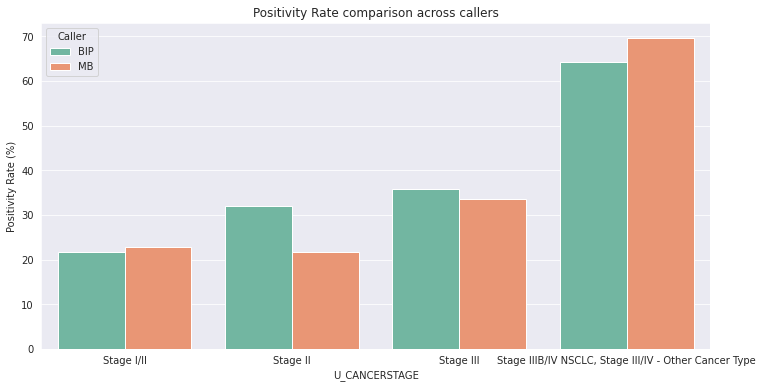

In [18]:
#generate comparison summary table between S3 and MB caller result with flipped call information groupby two columns
from scipy.stats import chi2_contingency, fisher_exact

def generate_comparsion_summary_test(df, groupby_cols, filename, work_dir=""):
    """
    Generate a summary comparing BIP caller and MB caller.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to generate summary for.
    - groupby_cols (list): The column names to group by. Expects a list of length 2.
    - filename (str): The name of the file to save the summary to.
    - work_dir (str, optional): The working directory to save the file. Default is current directory.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """

    if len(groupby_cols) != 2:
        raise ValueError("groupby_cols should have exactly 2 columns to group by.")

    # Group the DataFrame by the specified columns
    grouped = df.groupby(groupby_cols)

    # Initialize a list to store summary data
    summary_data = []

    # Iterate through groups
    for group_keys, group in grouped:

        # Total samples
        total_samples = len(group)

        # Filter samples based on various criteria
        positive_calls = group[group['methyl_call'] == 1]
        positive_calls_MB = group[group['MB_methyl_score'] > 0]

        # Various calculations
        positivity_rate = len(positive_calls) / total_samples
        positivity_rate_mb = len(positive_calls_MB) / total_samples

        bip_pos = len(positive_calls)
        bip_neg = total_samples - bip_pos

        mb_pos = len(positive_calls_MB)
        mb_neg = total_samples - mb_pos

        contingency = [[bip_pos, bip_neg], [mb_pos, mb_neg]]

        bip_only_count = len(positive_calls[~positive_calls.index.isin(positive_calls_MB.index)])
        mb_only_count = len(positive_calls_MB[~positive_calls_MB.index.isin(positive_calls.index)])
        consistent_calls_both = len(positive_calls[positive_calls.index.isin(positive_calls_MB.index)])

        # Conduct chi-square test or Fisher's exact test based on the data
        try:
            _, p_value, _, _ = chi2_contingency(contingency)
        except ValueError:
            _, p_value = fisher_exact(contingency)

        # Build the summary dictionary
        summary_dict = {
            groupby_cols[0]: group_keys[0],
            groupby_cols[1]: group_keys[1],
            'Positivity Rate (BIP caller)': f"{positivity_rate * 100:.1f}% (n={bip_pos}/{total_samples})",
            'Positivity Rate (MB caller)': f"{positivity_rate_mb * 100:.1f}% (n={mb_pos}/{total_samples})",
            'chi-square p value': p_value,
            'Median Tumor Fraction (BIP caller)': positive_calls['pred_frac'].median(),
            'Median Methylation Score (BIP caller)': positive_calls['methyl_score'].median(),
            'Median Tumor Fraction (MB caller)': positive_calls_MB['pred_frac'].median(),
            'Median Methylation Score (MB caller)': positive_calls_MB['MB_methyl_score'].median(),
            'Flipped Calls (BIP only)': bip_only_count,
            'Flipped Calls (MB only)': mb_only_count,
            'Consistent Calls (Both)': consistent_calls_both
        }

        # Append the summary dictionary to the list
        summary_data.append(summary_dict)


    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Convert Positivity Rate columns into a 'long' format for easier plotting
    bip_rates = summary_df[['Positivity Rate (BIP caller)', groupby_cols[0], groupby_cols[1]]].rename(columns={'Positivity Rate (BIP caller)': 'Positivity Rate'})
    bip_rates['Caller'] = 'BIP'
    
    mb_rates = summary_df[['Positivity Rate (MB caller)', groupby_cols[0], groupby_cols[1]]].rename(columns={'Positivity Rate (MB caller)': 'Positivity Rate'})
    mb_rates['Caller'] = 'MB'
    
    long_format_df = pd.concat([bip_rates, mb_rates])
    long_format_df['Positivity Rate'] = long_format_df['Positivity Rate'].str.extract('(\d+\.\d)').astype(float)  # Extract percentage value from string and convert to float

#     # Plotting using pointplot
#     plt.figure(figsize=(12, 6))
#     sns.pointplot(data=long_format_df, x=groupby_cols[1], y='Positivity Rate', hue='Caller', palette="Set2", dodge=0.3, join=False, markers=["o", "s"], capsize=0.1, errwidth=1)
#     plt.legend(title='Caller')
#     plt.title('Positivity Rate comparison between BIP and MB caller')
#     plt.ylabel('Positivity Rate (%)')
    
    # Plotting using barplot
    plt.figure(figsize=(12, 6))
    sns.set_style('darkgrid')
    sns.barplot(data=long_format_df, x=groupby_cols[1], y='Positivity Rate', hue='Caller', palette="Set2", dodge=True, ci=None)
    plt.title('Positivity Rate comparison across callers')
    plt.ylabel('Positivity Rate (%)')
    plt.show()


    # # Separate plots based on cancer type
    # for cancer_type in long_format_df[groupby_cols[0]].unique():
    #     subset_df = long_format_df[long_format_df[groupby_cols[0]] == cancer_type]
    #     plt.figure(figsize=(12, 6))
    #     sns.pointplot(data=subset_df, x=groupby_cols[1], y='Positivity Rate', hue='Caller', palette="Set2", dodge=0.3, join=False, markers=["o", "s"], capsize=0.1, errwidth=1)
    #     plt.legend(title='Caller')
    #     plt.title(f'Positivity Rate comparison between BIP and MB caller for {cancer_type}')
    #     plt.ylabel('Positivity Rate (%)')
    #     plt.show()

    # Save the DataFrame to the specified file in the working directory
    file_path = f"{work_dir}/{filename}"
    summary_df.to_csv(file_path, index=False)
    
    return summary_df



#generate comparasion table to for cancer type and stage
# Filter the dataframe to only include the specified cancer types
filtered_pos_calls_df = df_lung[df_lung['U_DIAGNOSIS'].isin(['Lung adenocarcinoma', 'Lung squamous cell carcinoma'])]
summary_compare_type_stage = generate_comparsion_summary_test(filtered_pos_calls_df, ['U_DIAGNOSIS', 'U_CANCERSTAGE'], 'lung_compare_summary_type_stage.csv', work_dir)

In [19]:
summary_compare_type_stage

,U_DIAGNOSIS,U_CANCERSTAGE,Positivity Rate (BIP caller),Positivity Rate (MB caller),chi-square p value,Median Tumor Fraction (BIP caller),Median Methylation Score (BIP caller),Median Tumor Fraction (MB caller),Median Methylation Score (MB caller),Flipped Calls (BIP only),Flipped Calls (MB only),Consistent Calls (Both)
0,Lung adenocarcinoma,Stage I/II,20.4% (n=11/54),14.8% (n=8/54),0.613249,0.001201,1.73256,0.001102,1.339874,6,3,5
1,Lung adenocarcinoma,Stage II,20.1% (n=30/149),16.8% (n=25/149),0.550315,0.001190,1.57905,0.000747,1.096875,16,11,14
2,Lung adenocarcinoma,Stage III,23.7% (n=55/232),21.1% (n=49/232),0.577785,0.001361,3.21268,0.001045,1.813516,25,19,30
3,Lung adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",28.3% (n=13/46),39.1% (n=18/46),0.377624,0.001201,3.80414,0.000723,1.116412,3,8,10
4,Lung squamous cell carcinoma,Stage I/II,23.1% (n=3/13),30.8% (n=4/13),1.000000,0.001578,1.22275,0.000789,1.397787,1,2,2
5,Lung squamous cell carcinoma,Stage II,44.1% (n=15/34),26.5% (n=9/34),0.204513,0.001028,1.42950,0.000966,1.714908,8,2,7
6,Lung squamous cell carcinoma,Stage III,48.1% (n=25/52),46.2% (n=24/52),1.000000,0.001299,3.69475,0.001269,1.873951,5,4,20
7,Lung squamous cell carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",100.0% (n=7/7),100.0% (n=7/7),1.000000,0.002663,11.06500,0.002663,6.979927,0,0,7


In [ ]:
from scipy.stats import chi2_contingency, fisher_exact

def cross_caller(df):
    """
    Generate a summary comparing detection rates of multiple callers.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to generate summary for.

    Returns:
    - pandas.DataFrame: The summary DataFrame.
    """
    
    callers = ['methyl_score_LR_CRC', 'methyl_score_LR_LUNG', 'methyl_score_LR_BREAST', 'methyl_score_MB_CRC', 'methyl_score_MB_LUNG']
    renamed_callers = {'methyl_score_LR_CRC': 'LR_CRC', 'methyl_score_LR_LUNG': 'LR_LUNG', 'methyl_score_LR_BREAST': 'LR_BREAST', 'methyl_score_MB_CRC': 'MB_CRC', 'methyl_score_MB_LUNG': 'MB_LUNG'}
    
    # Initialize a list to store summary data
    summary_data = []

    total_samples = len(df)

    for caller in callers:
        positive_calls = df[df[caller] > 0]
        positivity_rate = len(positive_calls) / total_samples
        
        summary_dict = {
            'Caller': renamed_callers[caller],
            'Positivity Rate': f"{positivity_rate * 100:.1f}% (n={len(positive_calls)}/{total_samples})"
        }
        
        summary_data.append(summary_dict)
        
    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Convert Positivity Rate column into a 'long' format for easier plotting
    summary_df['Positivity Rate Value'] = summary_df['Positivity Rate'].str.extract('(\d+\.\d)').astype(float)  # Extract percentage value from string and convert to float

    # Plotting using barplot
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 6))
    sns.set_style('darkgrid')
    sns.barplot(data=summary_df, x='Caller', y='Positivity Rate Value', ax = ax0)
    plt.title('Positivity Rate comparison across callers')
    plt.ylabel('Positivity Rate (%)')
    plt.show()
    
    return summary_df

In [23]:
summary_df

,Positivity Rate (BIP caller),Positivity Rate (MB caller),chi-square p value,Median Tumor Fraction (BIP caller),Median Methylation Score (BIP caller),Median Tumor Fraction (MB caller),Median Methylation Score (MB caller),Flipped Calls (BIP only),Flipped Calls (MB only),Consistent Calls (Both)
0,27.5% (n=171/621),25.0% (n=155/621),0.333356,0.001261,2.74765,0.001028,1.619202,67,51,104


# Data visualization

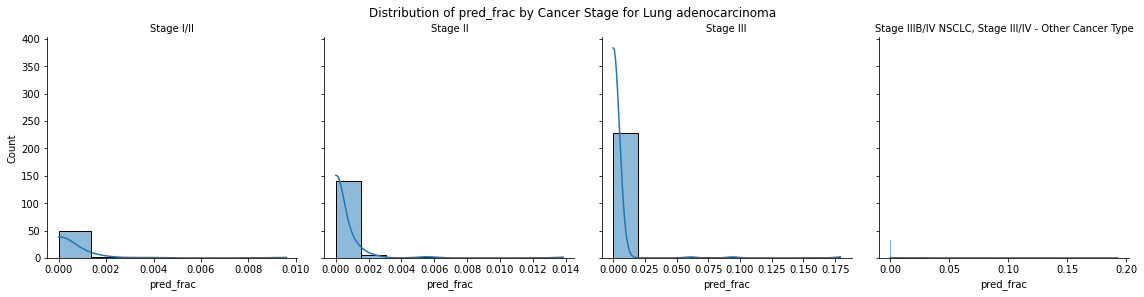

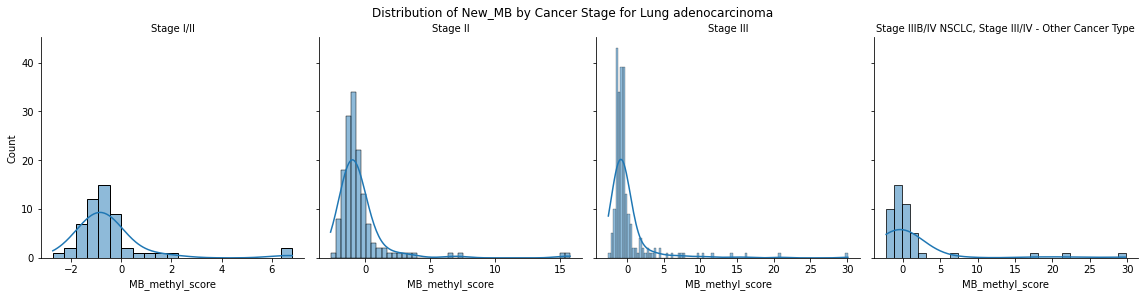

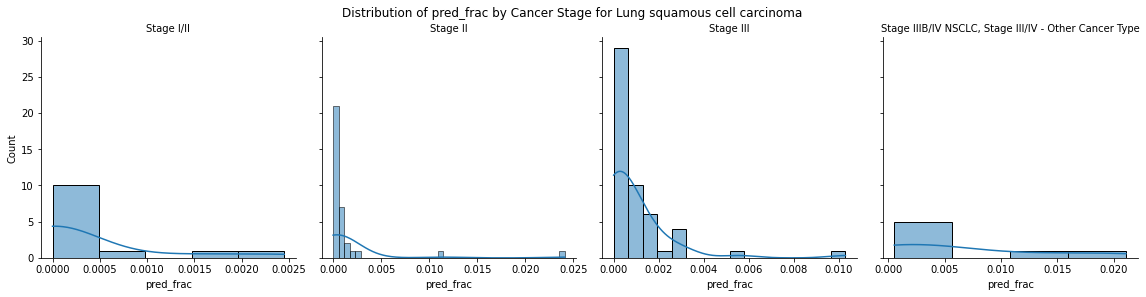

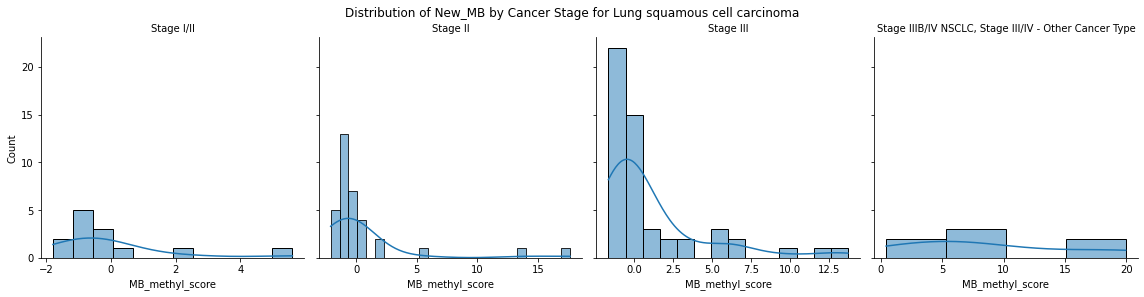

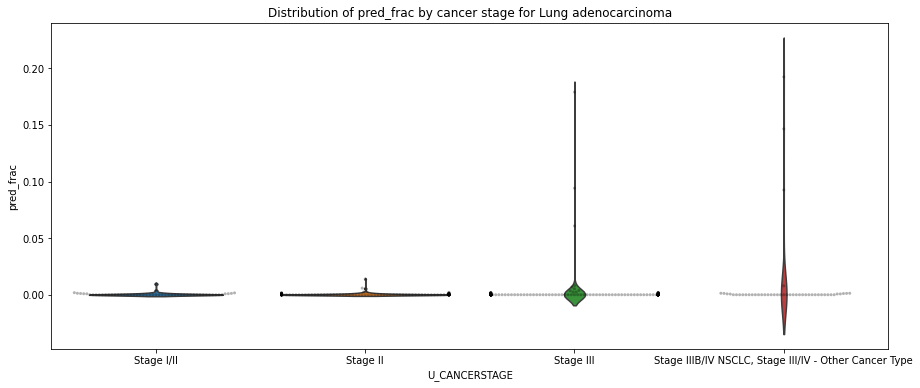

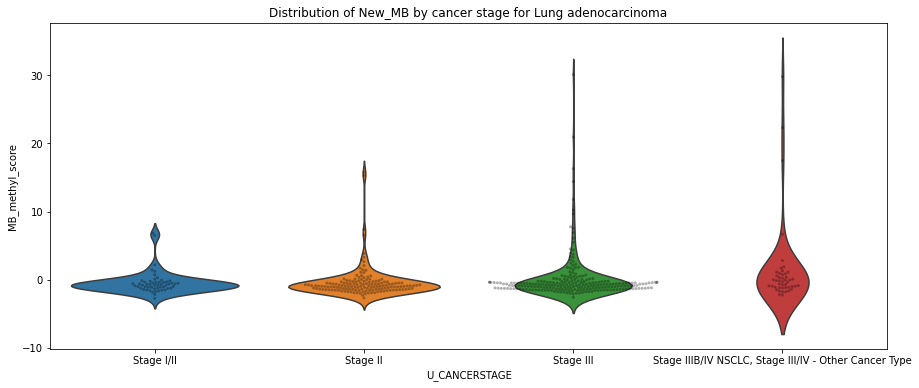

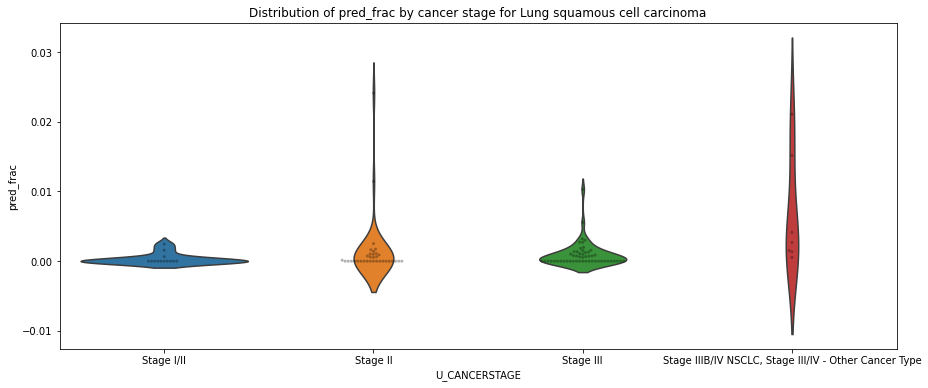

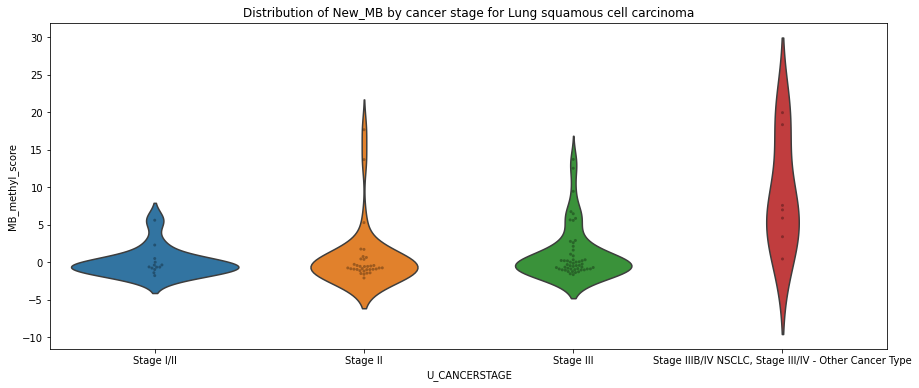

In [24]:
# Filter the dataframe to only include the specified cancer types
filtered_pos_calls_df = df_lung[df_lung['U_DIAGNOSIS'].isin(['Lung adenocarcinoma', 'Lung squamous cell carcinoma'])]

cancer_types = ['Lung adenocarcinoma', 'Lung squamous cell carcinoma']

# Order for the cancer stages
stage_order = [
    'Stage I/II',
    'Stage II',
    'Stage III',
    'Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type'
]
for cancer in cancer_types:
    filtered_df_for_cancer = filtered_pos_calls_df[filtered_pos_calls_df['U_DIAGNOSIS'] == cancer]
    
    # Separate plots for pred_frac ordered by the cancer stage for a particular cancer type
    g = sns.FacetGrid(filtered_df_for_cancer, col='U_CANCERSTAGE', col_wrap=4, height=4, sharex=False, col_order=stage_order)
    g.map(sns.histplot, 'pred_frac', kde=True)
    g.set_titles("{col_name}")
    g.fig.suptitle(f'Distribution of pred_frac by Cancer Stage for {cancer}', y=1.02)
    plt.show()

    # Separate plots for methyl_score ordered by the cancer stage for a particular cancer type
    g = sns.FacetGrid(filtered_df_for_cancer, col='U_CANCERSTAGE', col_wrap=4, height=4, sharex=False, col_order=stage_order)
    g.map(sns.histplot, 'MB_methyl_score', kde=True)
    g.set_titles("{col_name}")
    g.fig.suptitle(f'Distribution of New_MB by Cancer Stage for {cancer}', y=1.02)
    plt.show()
    

#violin plot   
for cancer in cancer_types:
    filtered_df_for_cancer = filtered_pos_calls_df[filtered_pos_calls_df['U_DIAGNOSIS'] == cancer]
    
    # Plot pred_frac by age_group using Violin Plots
    plt.figure(figsize=(15, 6))
    sns.violinplot(x='U_CANCERSTAGE', y='pred_frac', data=filtered_df_for_cancer, order=stage_order, inner=None)
    sns.swarmplot(x='U_CANCERSTAGE', y='pred_frac', data=filtered_df_for_cancer, order=stage_order, color='k', size=3, alpha = 0.3)
    plt.title(f'Distribution of pred_frac by cancer stage for {cancer}')
    plt.show()

    # Plot New_MB (previously methyl_score) by age_group using Violin Plots
    plt.figure(figsize=(15, 6))
    sns.violinplot(x='U_CANCERSTAGE', y='MB_methyl_score', data=filtered_df_for_cancer, order=stage_order, inner=None)
    sns.swarmplot(x='U_CANCERSTAGE', y='MB_methyl_score', data=filtered_df_for_cancer, order=stage_order, color='k', size=3, alpha = 0.3)
    plt.title(f'Distribution of New_MB by cancer stage for {cancer}')
    plt.show()

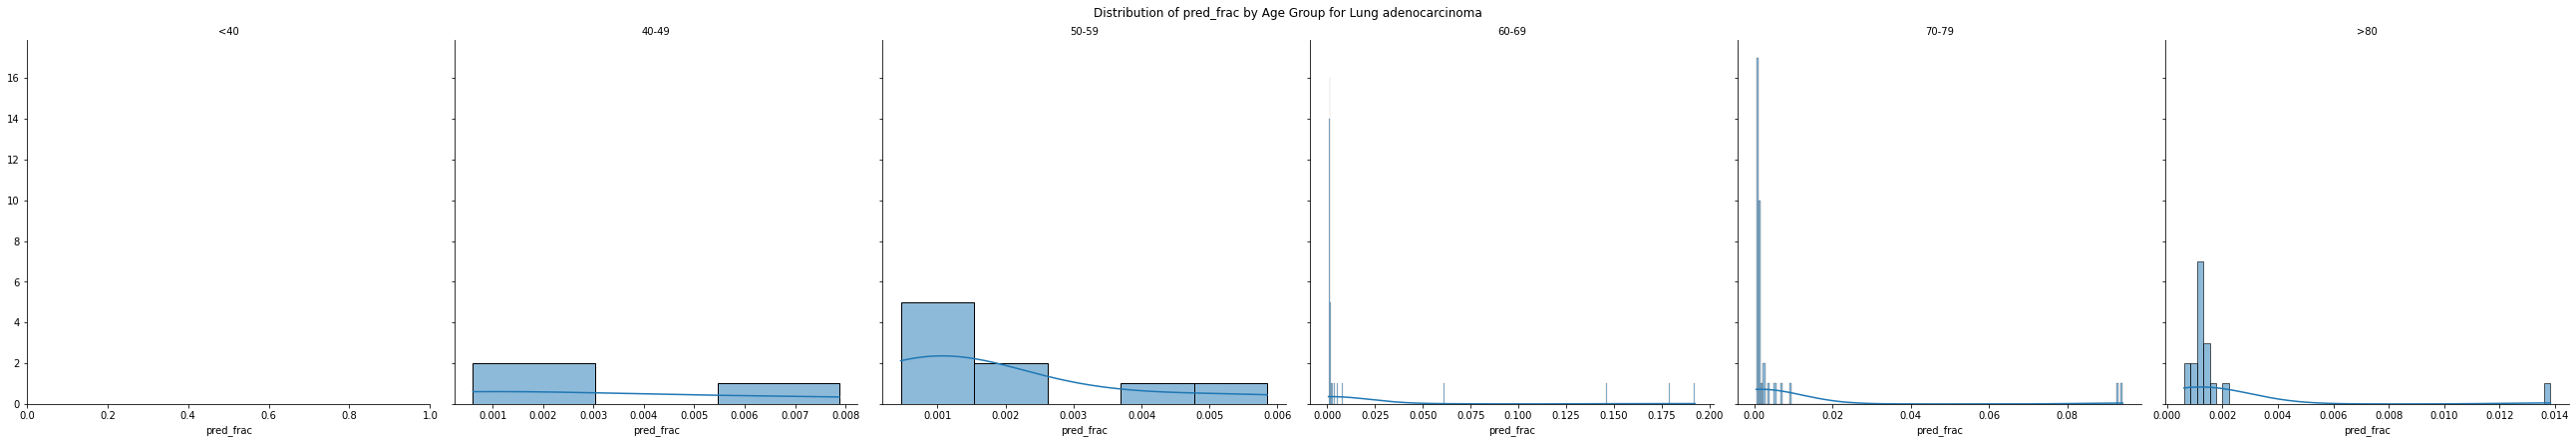

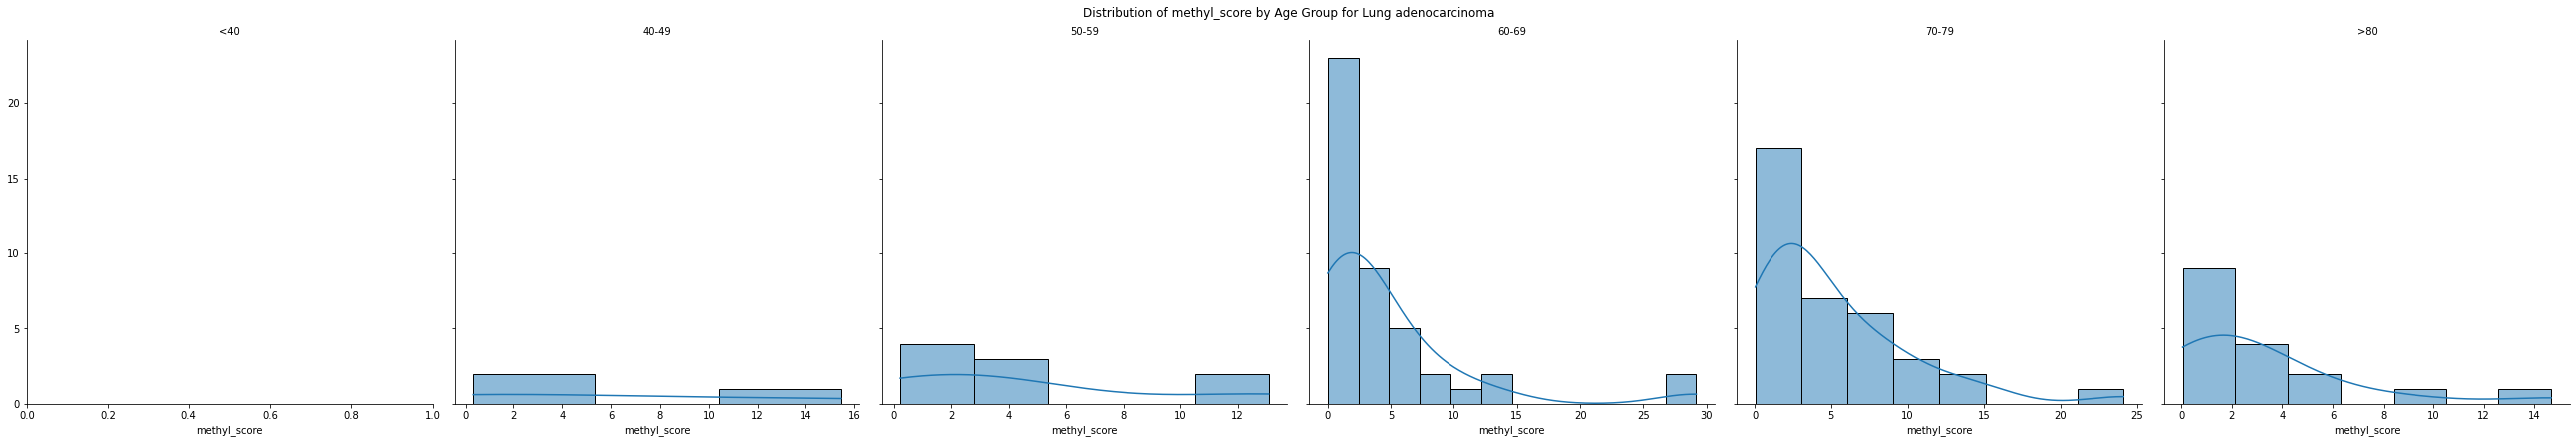

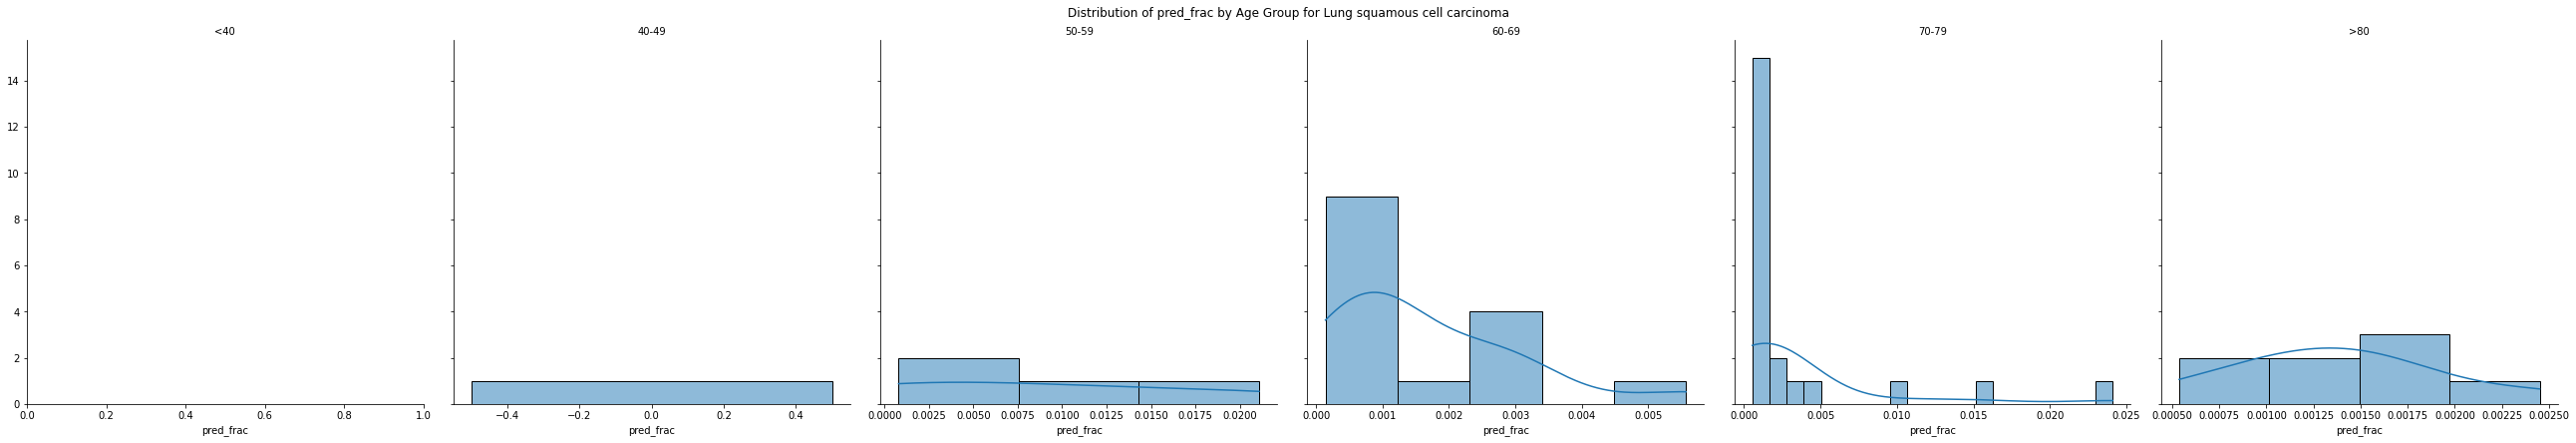

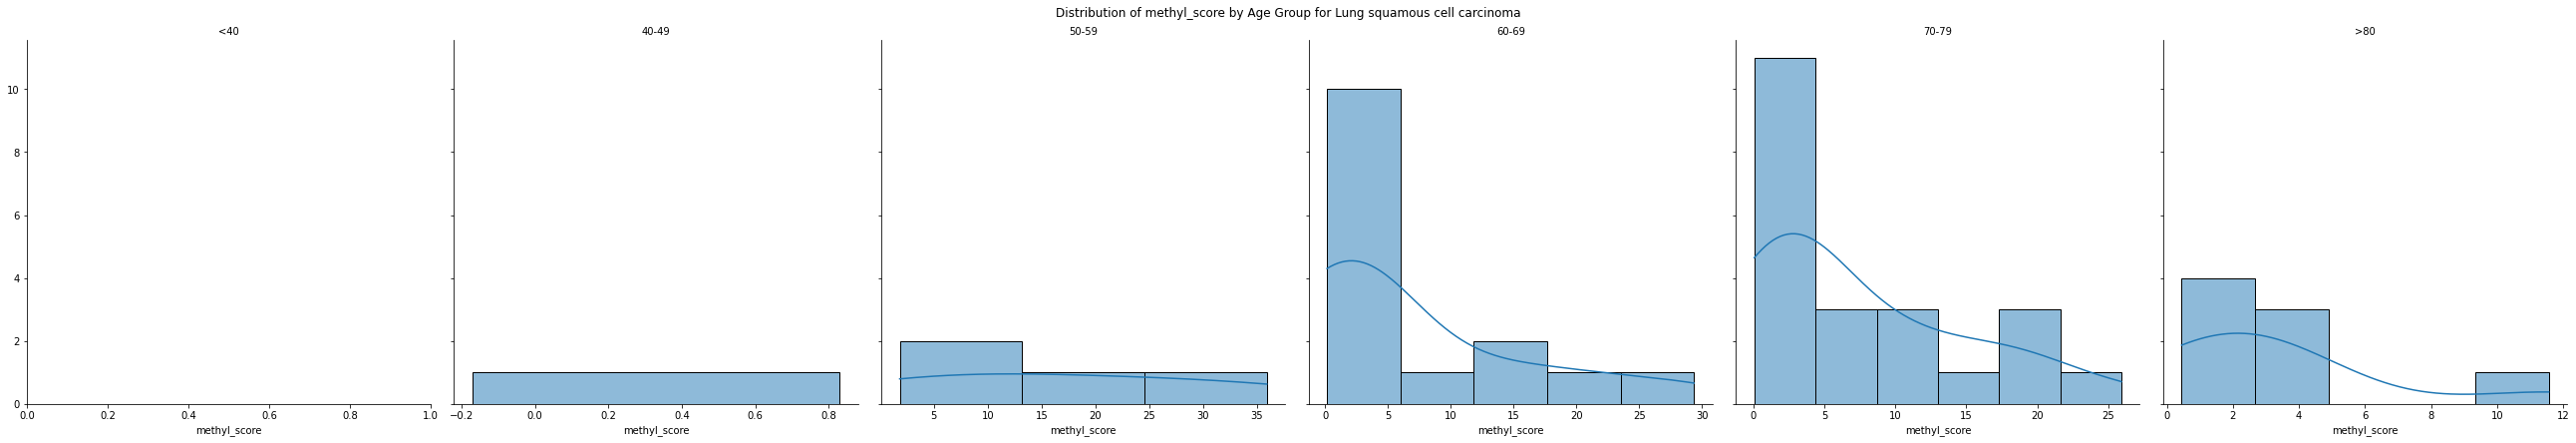

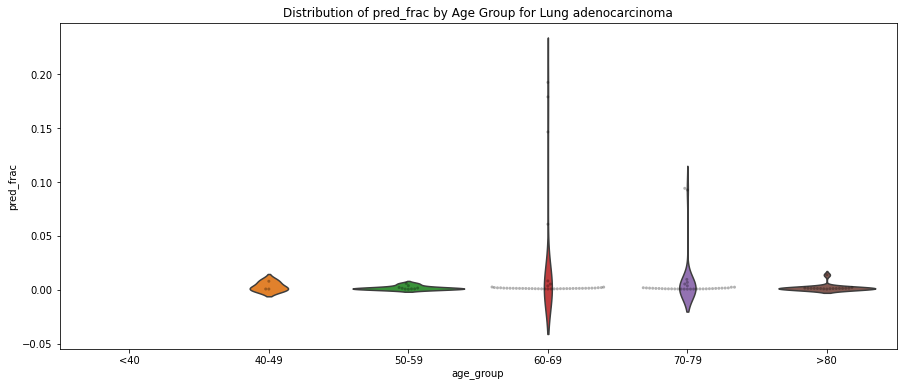

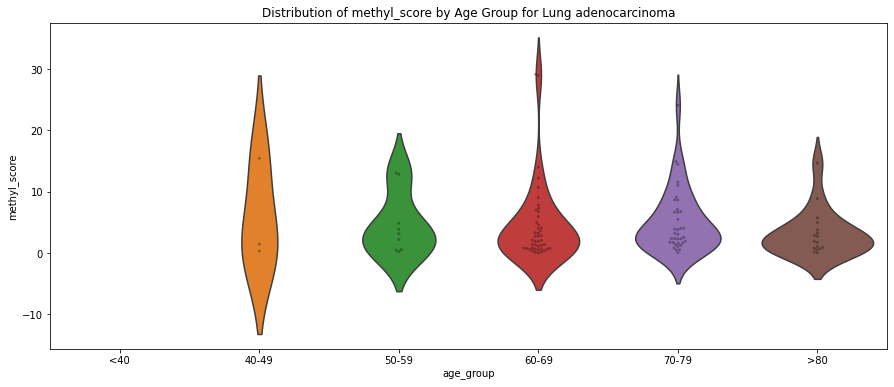

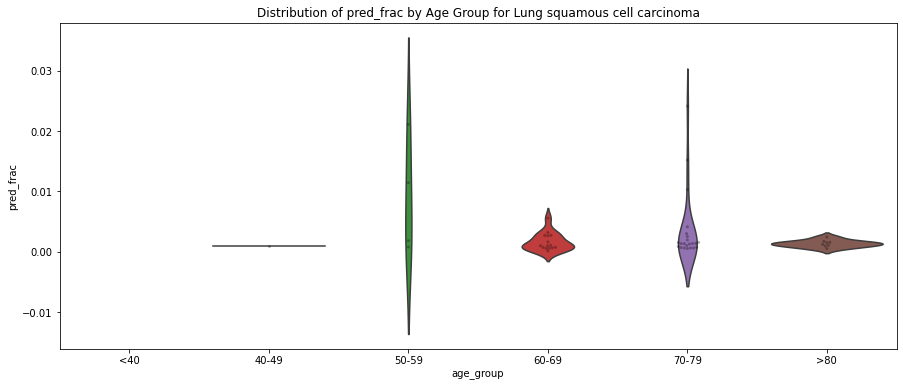

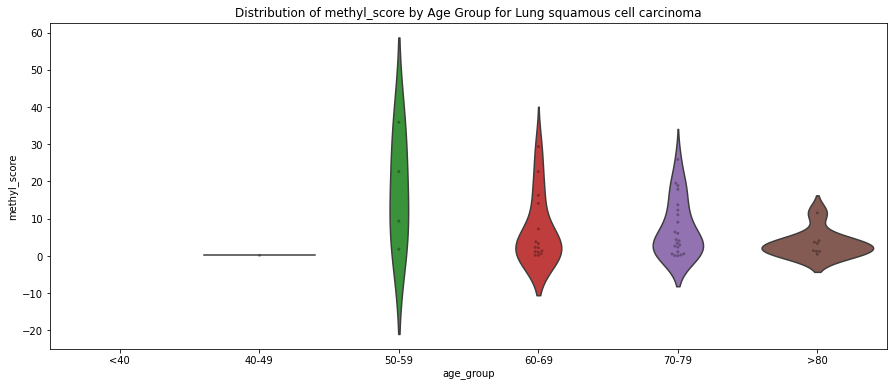

In [32]:
# Filter out samples where "call" == 1
filtered_pos_calls_df = df_lung[(df_lung['U_DIAGNOSIS'].isin(['Lung adenocarcinoma', 'Lung squamous cell carcinoma'])) & (df_lung['methyl_call'] == 1)]

age_order = ['<40', '40-49', '50-59', '60-69', '70-79', '>80']

cancer_types = ['Lung adenocarcinoma', 'Lung squamous cell carcinoma']

for cancer in cancer_types:
    filtered_df_for_cancer = filtered_pos_calls_df[filtered_pos_calls_df['U_DIAGNOSIS'] == cancer]
    
    # Plot pred_frac by age_group
    g = sns.FacetGrid(filtered_df_for_cancer, col='age_group', col_wrap=6, height=6, sharex=False, col_order=age_order)
    g.map(sns.histplot, 'pred_frac', kde=True)
    g.set_titles("{col_name}")
    g.fig.suptitle(f'Distribution of pred_frac by Age Group for {cancer}', y=1.02)
    plt.show()

    # Plot methyl_score by age_group
    g = sns.FacetGrid(filtered_df_for_cancer, col='age_group', col_wrap=6, height=6, sharex=False, col_order=age_order)
    g.map(sns.histplot, 'methyl_score', kde=True)
    g.set_titles("{col_name}")
    g.fig.suptitle(f'Distribution of methyl_score by Age Group for {cancer}', y=1.02)
    plt.show()

#violin plot   
for cancer in cancer_types:
    filtered_df_for_cancer = filtered_pos_calls_df[filtered_pos_calls_df['U_DIAGNOSIS'] == cancer]
    
    # Plot pred_frac by age_group using Violin Plots
    plt.figure(figsize=(15, 6))
    sns.violinplot(x='age_group', y='pred_frac', data=filtered_df_for_cancer, order=age_order, inner=None)
    sns.swarmplot(x='age_group', y='pred_frac', data=filtered_df_for_cancer, order=age_order, color='k', size=3, alpha = 0.3)
    plt.title(f'Distribution of pred_frac by Age Group for {cancer}')
    plt.show()

    # Plot New_MB (previously methyl_score) by age_group using Violin Plots
    plt.figure(figsize=(15, 6))
    sns.violinplot(x='age_group', y='methyl_score', data=filtered_df_for_cancer, order=age_order, inner=None)
    sns.swarmplot(x='age_group', y='methyl_score', data=filtered_df_for_cancer, order=age_order, color='k', size=3, alpha = 0.3)
    plt.title(f'Distribution of methyl_score by Age Group for {cancer}')
    plt.show()

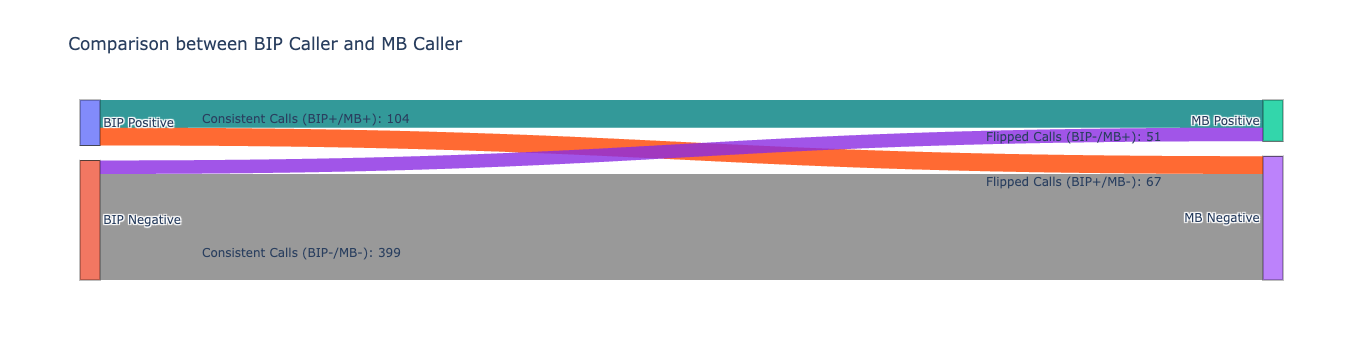

In [31]:
import plotly.graph_objects as go

# Create the alluvial data frame
alluvial_df = pd.DataFrame({
    'BIP Caller': ['Positive' if val == 1 else 'Negative' for val in df_lung['methyl_call']],
    'MB Caller': ['Positive' if val > 0 else 'Negative' for val in df_lung['MB_methyl_score']]
})

# Calculate the counts
bip_only_count = len(alluvial_df[(alluvial_df['BIP Caller'] == 'Positive') & (alluvial_df['MB Caller'] == 'Negative')])
mb_only_count = len(alluvial_df[(alluvial_df['BIP Caller'] == 'Negative') & (alluvial_df['MB Caller'] == 'Positive')])
both_positive_count = len(alluvial_df[(alluvial_df['BIP Caller'] == 'Positive') & (alluvial_df['MB Caller'] == 'Positive')])
both_negative_count = len(alluvial_df[(alluvial_df['BIP Caller'] == 'Negative') & (alluvial_df['MB Caller'] == 'Negative')])

# Define Sankey diagram structure
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["BIP Positive", "BIP Negative", "MB Positive", "MB Negative"],
    ),
    link = dict(
      source = [0, 0, 1, 1],
      target = [2, 3, 2, 3],
      value = [both_positive_count, bip_only_count, mb_only_count, both_negative_count],
      color = ['rgba(0, 128, 128, 0.8)', 'rgba(255, 69, 0, 0.8)', 'rgba(138, 43, 226, 0.8)', 'rgba(128, 128, 128, 0.8)']
  ))])

# Add annotations
annotations = [
    go.layout.Annotation(x=0.1, y=0.95, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (BIP+/MB+): {both_positive_count}'),
    go.layout.Annotation(x=0.1, y=0.1, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (BIP-/MB-): {both_negative_count}'),
    go.layout.Annotation(x=0.9, y=0.55, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (BIP+/MB-): {bip_only_count}'),
    go.layout.Annotation(x=0.9, y=0.85, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (BIP-/MB+): {mb_only_count}')
]

fig.update_layout(title_text="Comparison between BIP Caller and MB Caller", annotations=annotations)

fig.show()
